# Generating SQL for SQLite using Ollama, ChromaDB
This notebook runs through the process of using the `vanna` Python package to generate SQL using AI (RAG + LLMs) including connecting to a database and training. If you're not ready to train on your own database, you can still try it using a sample [SQLite database](app.md).

## Setup

In [1]:
from api_key_store import ApiKeyStore
api_key = ApiKeyStore().get_api_key("ANTHROPIC")
# print(openai_api_key)

In [2]:
import warnings
import re

warnings.filterwarnings('ignore', category=DeprecationWarning, message='^Number of requested results')
# warnings.filterwarnings('ignore', category=DeprecationWarning, message=re.escape(r'^Some regex pattern'))

import os

import re
from time import time
from datetime import datetime 

# from vanna.ollama import Ollama
# from vanna.openai import OpenAI_Chat
# from vanna.google import GoogleGeminiChat
from vanna.anthropic import Anthropic_Chat
from vanna.chromadb.chromadb_vector import ChromaDB_VectorStore

In [3]:
model_name = "claude-3-sonnet-20240229" #  "claude-3-5-sonnet-20241022"  # 
file_db = "~/Downloads/chinook.sqlite"

CONFIG = {
    'model': model_name,   # 'mistral' # "starcoder2"
    'api_key': api_key,     
}

file_db = "~/Downloads/datasets/chinook.db"

clean_and_train = True  # False  

sql_id = 1
NUM_RETRY = 3

In [4]:
class MyVanna(ChromaDB_VectorStore, Anthropic_Chat):
    def __init__(self, config=None):
        ChromaDB_VectorStore.__init__(self, config=config)
        Anthropic_Chat.__init__(self, config=config)
        

In [5]:
def remove_collections(collection_name=None, ACCEPTED_TYPES = ["sql", "ddl", "documentation"]):
    if not collection_name:
        collections = ACCEPTED_TYPES
    elif isinstance(collection_name, str):
        collections = [collection_name]
    elif isinstance(collection_name, list):
        collections = collection_name
    else:
        print(f"\t{collection_name} is unknown: Skipped")
        return

    for c in collections:
        if not c in ACCEPTED_TYPES:
            print(f"\t{c} is unknown: Skipped")
            continue
            
        # print(f"vn.remove_collection('{c}')")
        vn.remove_collection(c)

def strip_brackets(ddl):
    """
    This function removes square brackets from table and column names in a DDL script.
    
    Args:
        ddl (str): The DDL script containing square brackets.
    
    Returns:
        str: The DDL script with square brackets removed.
    """
    # Use regular expressions to match and replace square brackets
    pattern = r"\[([^\]]+)]"  # Match any character except ] within square brackets
    return re.sub(pattern, r"\1", ddl)

In [6]:
vn = MyVanna(config=CONFIG)

In [7]:
hostname = os.uname().nodename
print("Hostname:", hostname)

Hostname: ducklover1


In [8]:
file_db = os.path.abspath(os.path.expanduser(file_db))
vn.connect_to_sqlite(file_db)

In [9]:
vn.run_sql_is_set

True

In [10]:
if clean_and_train:
    remove_collections()

## Training
You only need to train once. Do not train again unless you want to add more training data.

In [11]:
# show training data
training_data = vn.get_training_data()
training_data

,id,question,content,training_data_type


In [12]:
df_ddl = vn.run_sql("SELECT type, sql FROM sqlite_master WHERE sql is not null")

In [13]:
df_ddl

,type,sql
0,table,"CREATE TABLE ""albums""\r\n(\r\n [AlbumId] IN..."
1,table,"CREATE TABLE sqlite_sequence(name,seq)"
2,table,"CREATE TABLE ""artists""\r\n(\r\n [ArtistId] ..."
3,table,"CREATE TABLE ""customers""\r\n(\r\n [Customer..."
4,table,"CREATE TABLE ""employees""\r\n(\r\n [Employee..."
5,table,"CREATE TABLE ""genres""\r\n(\r\n [GenreId] IN..."
6,table,"CREATE TABLE ""invoices""\r\n(\r\n [InvoiceId..."
7,table,"CREATE TABLE ""invoice_items""\r\n(\r\n [Invo..."
8,table,"CREATE TABLE ""media_types""\r\n(\r\n [MediaT..."
9,table,"CREATE TABLE ""playlists""\r\n(\r\n [Playlist..."


In [14]:
if clean_and_train:
    for ddl in df_ddl['sql'].to_list():
        ddl = strip_brackets(ddl)
        vn.train(ddl=ddl)

    # Sometimes you may want to add documentation about your business terminology or definitions.
    vn.train(documentation="In the chinook database invoice means order")

Adding ddl: CREATE TABLE "albums"
(
    AlbumId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    Title NVARCHAR(160)  NOT NULL,
    ArtistId INTEGER  NOT NULL,
    FOREIGN KEY (ArtistId) REFERENCES "artists" (ArtistId) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
)
Adding ddl: CREATE TABLE sqlite_sequence(name,seq)
Adding ddl: CREATE TABLE "artists"
(
    ArtistId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    Name NVARCHAR(120)
)
Adding ddl: CREATE TABLE "customers"
(
    CustomerId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    FirstName NVARCHAR(40)  NOT NULL,
    LastName NVARCHAR(20)  NOT NULL,
    Company NVARCHAR(80),
    Address NVARCHAR(70),
    City NVARCHAR(40),
    State NVARCHAR(40),
    Country NVARCHAR(40),
    PostalCode NVARCHAR(10),
    Phone NVARCHAR(24),
    Fax NVARCHAR(24),
    Email NVARCHAR(60)  NOT NULL,
    SupportRepId INTEGER,
    FOREIGN KEY (SupportRepId) REFERENCES "employees" (EmployeeId) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
)
Adding ddl: CREATE TAB

## Asking the AI
Whenever you ask a new question, it will find the 10 most relevant pieces of training data and use it as part of the LLM prompt to generate the SQL.

### warm-up





# QUESTION :  How many customers are there


Using model claude-3-sonnet-20240229 for 694.0 tokens (approx)

[( EXTRACTED SQL )]
SELECT COUNT(*) FROM customers;


[( <SQL> )]
generated SQL statement



SELECT COUNT(*) FROM customers;


[( <DataFrame> )]
queried dataframe



,COUNT(*)
0,59


Using model claude-3-sonnet-20240229 for 161.25 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

fig = go.Figure(go.Indicator(
    mode="number",
    value=df['COUNT(*)'].iloc[0],
    title={"text": "Number of Customers"}
))

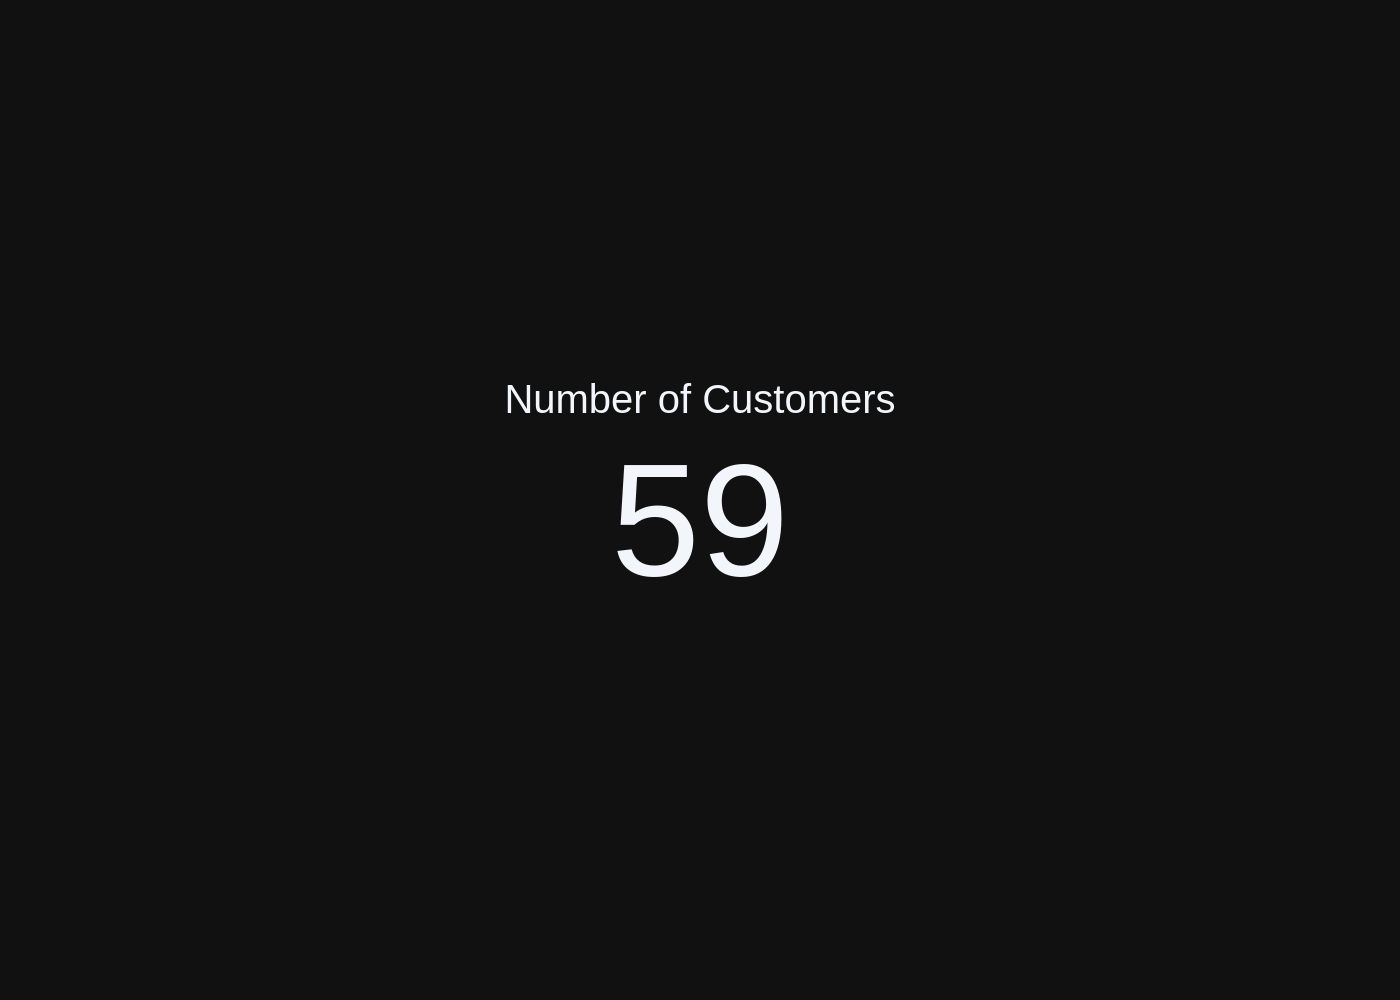

elapsed_time = 3.5562572479248047


In [15]:
ts_start = time()
question = "How many customers are there"
resp = vn.ask_adaptive(question=question)
ts_stop = time()
elapsed_time = ts_stop - ts_start
print(f"elapsed_time = {elapsed_time}")

In [16]:
### Loop over questions

In [17]:
questions = [
    "Can you list all tables in the SQLite database catalog?",
    "which table stores customer's orders",
    "How many customers are there",
    "what are the top 5 countries that customers come from?",
    "List all albums and their corresponding artist names  ",
    """Find all tracks with a name containing "What" (case-insensitive) """,
    "Get the total number of invoices for each customer",
    "Find the total number of invoices per country",
    "List all invoices with a total exceeding $10",
    "Find all invoices since 2010 and the total amount invoiced:",
    "List all employees and their reporting manager's name (if any):",
    " Get the average invoice total for each customer:",
    "Find the top 5 most expensive tracks (based on unit price):",
    "List all genres and the number of tracks in each genre:",
    "Get all genres that do not have any tracks associated with them:",
    "List all customers who have not placed any orders:",
    """ 
        Can you find the top 10 most popular artists based on the number of tracks?
        Hint: There are 3 tables - artists, albums and tracks, 
        where albums and artists are linked by ArtistId, albums and tracks are linked by AlbumId,
    """,
    "List all customers from Canada and their email addresses:",
    "Find the customer with the most invoices ",
    "Find the customer who bought the most albums in total quantity (across all invoices):",
    """      
        Find the top 5 customers who bought the most albums in total quantity (across all invoices):
        Hint: album quantity is found in invoice_items, 
    """,
    """  
         Find the top 5 customers who spent the most money overall,  
         Hint: order total can be found on invoices table, calculation using invoice_items detail table is unnecessary 
    """,
    "Get all playlists containing at least 10 tracks and the total duration of those tracks:",
    "Identify artists who have albums with tracks appearing in multiple genres:",
]





# QUESTION  - 2:  Can you list all tables in the SQLite database catalog?


Using model claude-3-sonnet-20240229 for 700.75 tokens (approx)

[( EXTRACTED SQL )]
SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;


[( <SQL> )]
generated SQL statement



SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;


[( <DataFrame> )]
queried dataframe



,name
0,albums
1,artists
2,customers
3,employees
4,genres
5,invoice_items
6,invoices
7,media_types
8,playlist_track
9,playlists


Using model claude-3-sonnet-20240229 for 175.5 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="gauge+number",
        value=df['name'].values[0],
        title={'text': "Table Name"}
    ))
else:
    fig = go.Figure(data=[go.Table(
        header=dict(values=list(df.columns)),
        cells=dict(values=[df[col] for col in df.columns])
    )])

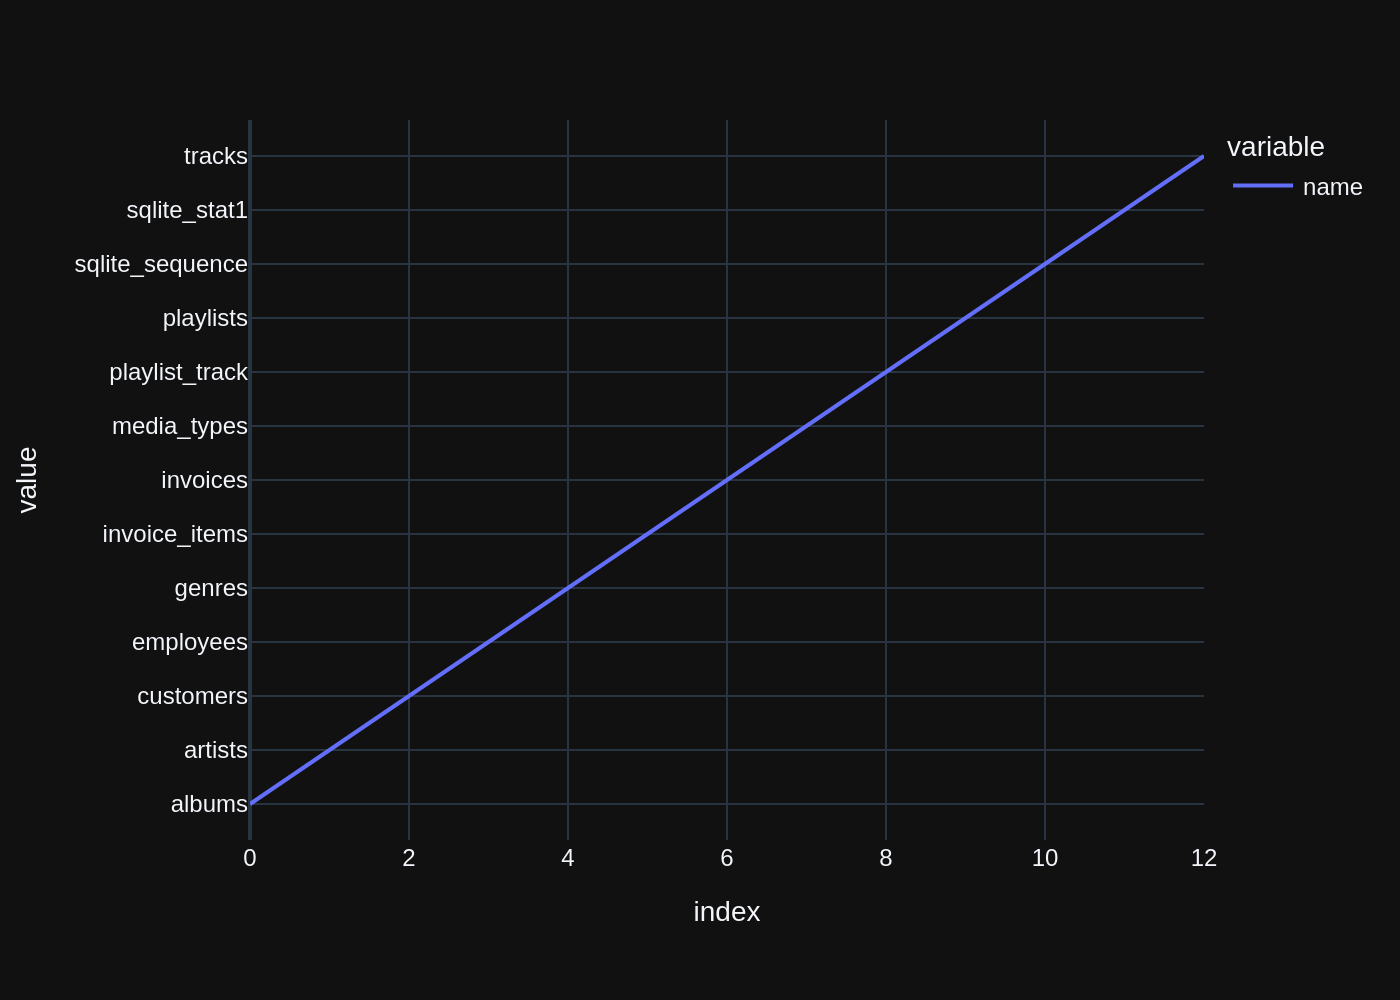





# QUESTION  - 3:  which table stores customer's orders


Using model claude-3-sonnet-20240229 for 738.0 tokens (approx)

[( RETRY )]
***** 1 *****

Using model claude-3-sonnet-20240229 for 880.0 tokens (approx)

[( RETRY )]
***** 2 *****

Using model claude-3-sonnet-20240229 for 1011.25 tokens (approx)

[( RETRY )]
***** 3 *****

Using model claude-3-sonnet-20240229 for 1142.5 tokens (approx)




# QUESTION  - 4:  How many customers are there


Using model claude-3-sonnet-20240229 for 742.5 tokens (approx)

[( EXTRACTED SQL )]
SELECT COUNT(*) FROM customers;


[( <SQL> )]
generated SQL statement



SELECT COUNT(*) FROM customers;


[( <DataFrame> )]
queried dataframe



,COUNT(*)
0,59


Using model claude-3-sonnet-20240229 for 161.25 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

fig = go.Figure(go.Indicator(
    mode="number",
    value=df['COUNT(*)'].iloc[0],
    title={"text": "Number of Customers"}
))

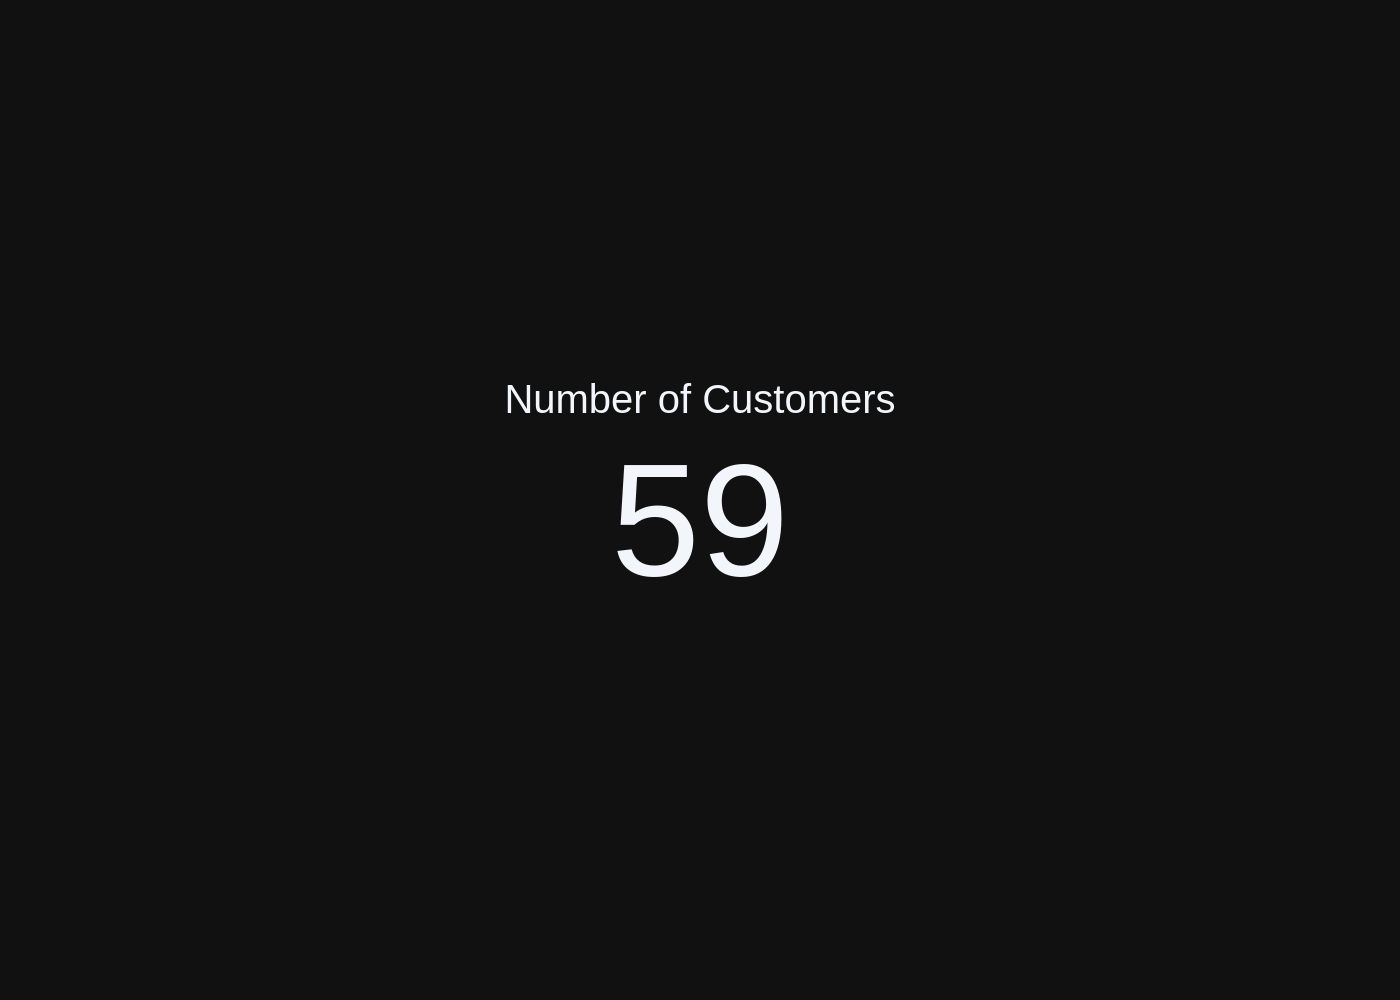





# QUESTION  - 5:  what are the top 5 countries that customers come from?


Using model claude-3-sonnet-20240229 for 750.25 tokens (approx)

[( EXTRACTED SQL )]
SELECT Country, COUNT(*) AS num_customers
FROM customers
GROUP BY Country
ORDER BY num_customers DESC
LIMIT 5;


[( <SQL> )]
generated SQL statement



SELECT Country, COUNT(*) AS num_customers
FROM customers
GROUP BY Country
ORDER BY num_customers DESC
LIMIT 5;


[( <DataFrame> )]
queried dataframe



,Country,num_customers
0,USA,13
1,Canada,8
2,France,5
3,Brazil,5
4,Germany,4


Using model claude-3-sonnet-20240229 for 193.0 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['num_customers'].values[0],
        title={"text": f"Number of Customers from {df['Country'].values[0]}"}
    ))
else:
    fig = go.Figure([go.Bar(x=df['Country'], y=df['num_customers'])])
    fig.update_layout(
        title="Top 5 Countries by Number of Customers",
        xaxis_title="Country",
        yaxis_title="Number of Customers"
    )

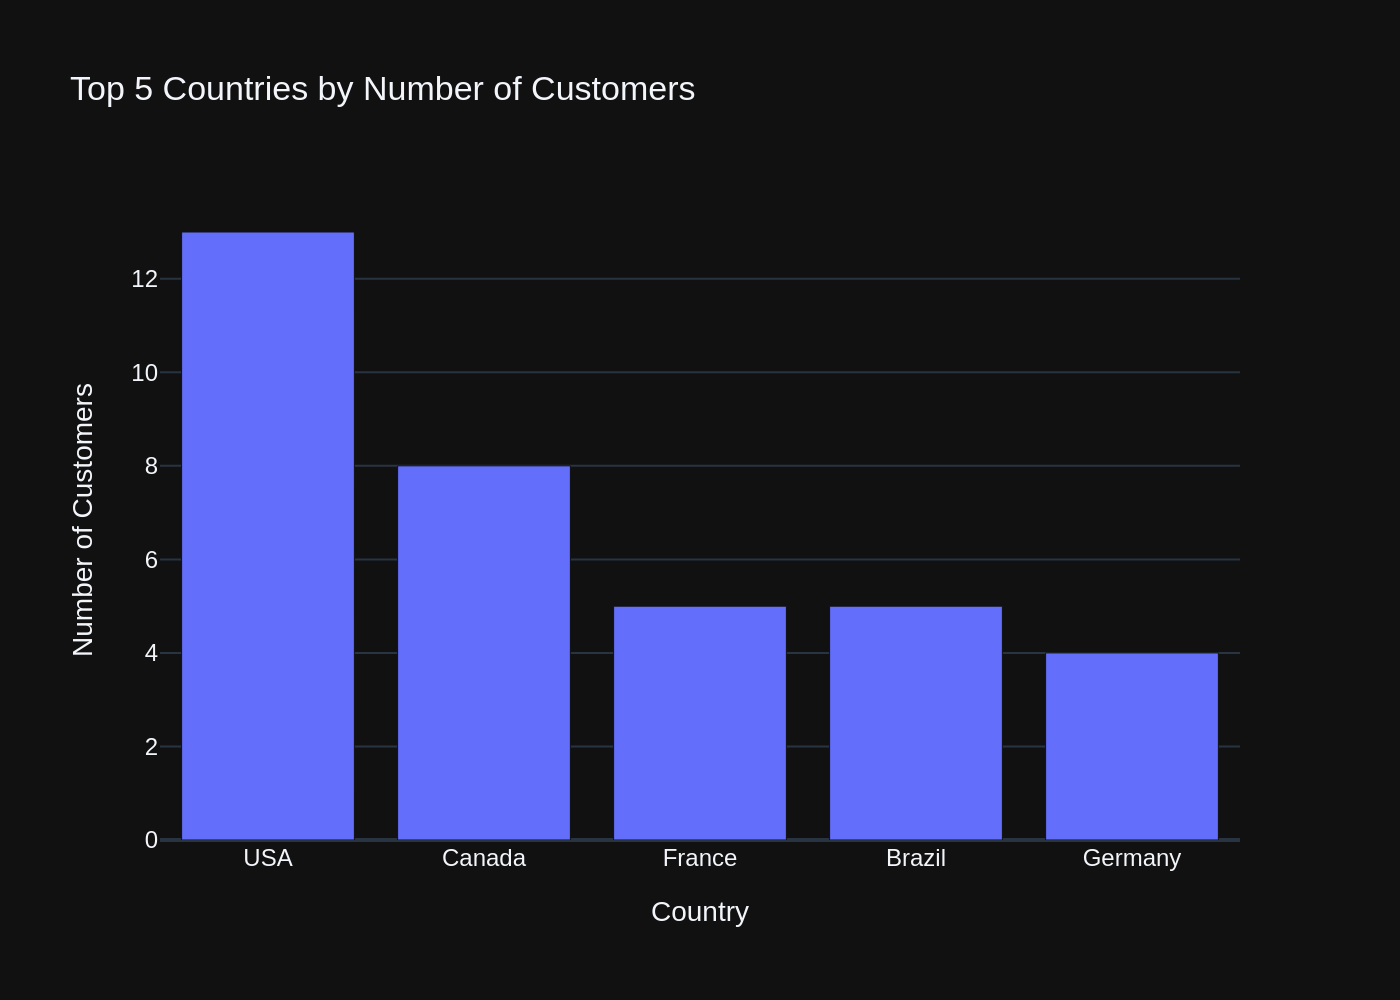





# QUESTION  - 6:  List all albums and their corresponding artist names  


Using model claude-3-sonnet-20240229 for 749.0 tokens (approx)

[( EXTRACTED SQL )]
SELECT a.Title AS Album, ar.Name AS Artist
FROM albums a
JOIN artists ar ON a.ArtistId = ar.ArtistId
ORDER BY Album;


[( <SQL> )]
generated SQL statement



SELECT a.Title AS Album, ar.Name AS Artist
FROM albums a
JOIN artists ar ON a.ArtistId = ar.ArtistId
ORDER BY Album;


[( <DataFrame> )]
queried dataframe



,Album,Artist
0,...And Justice For All,Metallica
1,20th Century Masters - The Millennium Collecti...,Scorpions
2,"A Copland Celebration, Vol. I",Aaron Copland & London Symphony Orchestra
3,A Matter of Life and Death,Iron Maiden
4,A Real Dead One,Iron Maiden
5,A Real Live One,Iron Maiden
6,A Soprano Inspired,"Britten Sinfonia, Ivor Bolton & Lesley Garrett"
7,A TempestadeTempestade Ou O Livro Dos Dias,Legião Urbana
8,A-Sides,Soundgarden
9,Ace Of Spades,Motörhead


Using model claude-3-sonnet-20240229 for 193.0 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="gauge+number",
        value=df.iloc[0, 1],
        title={'text': df.iloc[0, 0]},
        domain={'x': [0, 1], 'y': [0, 1]}
    ))
else:
    fig = go.Figure()
    fig.add_trace(go.Bar(x=df['Album'], y=df['Artist'], text=df['Artist']))
    fig.update_layout(title='Albums and Artists', xaxis_title='Album', yaxis_title='Artist')

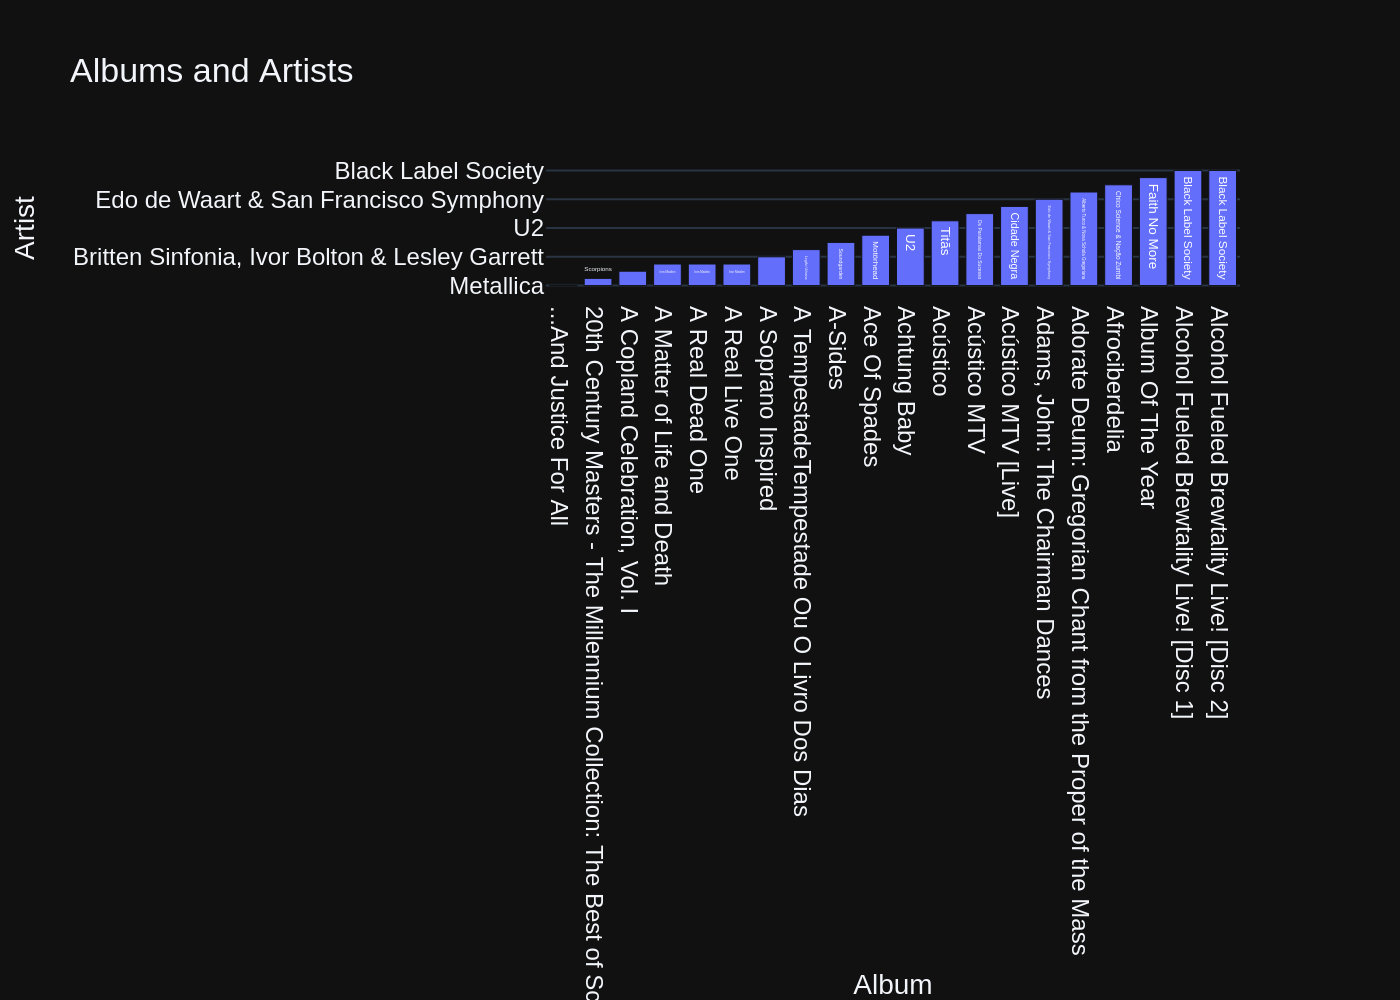





# QUESTION  - 7:  Find all tracks with a name containing "What" (case-insensitive) 


Using model claude-3-sonnet-20240229 for 816.25 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT * 
FROM tracks
WHERE UPPER(Name) LIKE '%WHAT%'
LIMIT 20


[( <DataFrame> )]
queried dataframe



,TrackId,Name,AlbumId,MediaTypeId,GenreId,Composer,Milliseconds,Bytes,UnitPrice
0,26,What It Takes,5,1,1,"Steven Tyler, Joe Perry, Desmond Child",310622,10144730,0.99
1,88,What You Are,10,1,1,Audioslave/Chris Cornell,249391,5988186,0.99
2,130,Do what cha wanna,13,1,2,George Duke,274155,9018565,0.99
3,342,What is and Should Never Be,30,1,1,Jimmy Page/Robert Plant,260675,8497116,0.99
4,607,So What,48,1,2,Miles Davis,564009,18360449,0.99
5,960,What A Day,76,1,1,"Mike Bordin, Billy Gould, Mike Patton",158275,5203430,0.99
6,1000,What If I Do?,80,1,1,"Dave Grohl, Taylor Hawkins, Nate Mendel, Chris...",302994,9929799,0.99
7,1039,What Now My Love,83,1,12,carl sigman/gilbert becaud/pierre leroyer,149995,4913383,0.99
8,1145,Whatsername,89,1,4,Green Day,252316,8244843,0.99
9,1440,"Whatever It Is, I Just Can't Stop",116,1,1,"Jay Kay/Kay, Jay",247222,8249453,0.99


Using model claude-3-sonnet-20240229 for 225.75 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="gauge+number",
        value=df.iloc[0]["UnitPrice"],
        title={'text': df.iloc[0]["Name"]},
        domain={'x': [0, 1], 'y': [0, 1]}
    ))
else:
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df.index, y=df["UnitPrice"], mode='markers', marker_size=10))
    fig.update_layout(title="Track Unit Prices", xaxis_title="Track Index", yaxis_title="Unit Price")

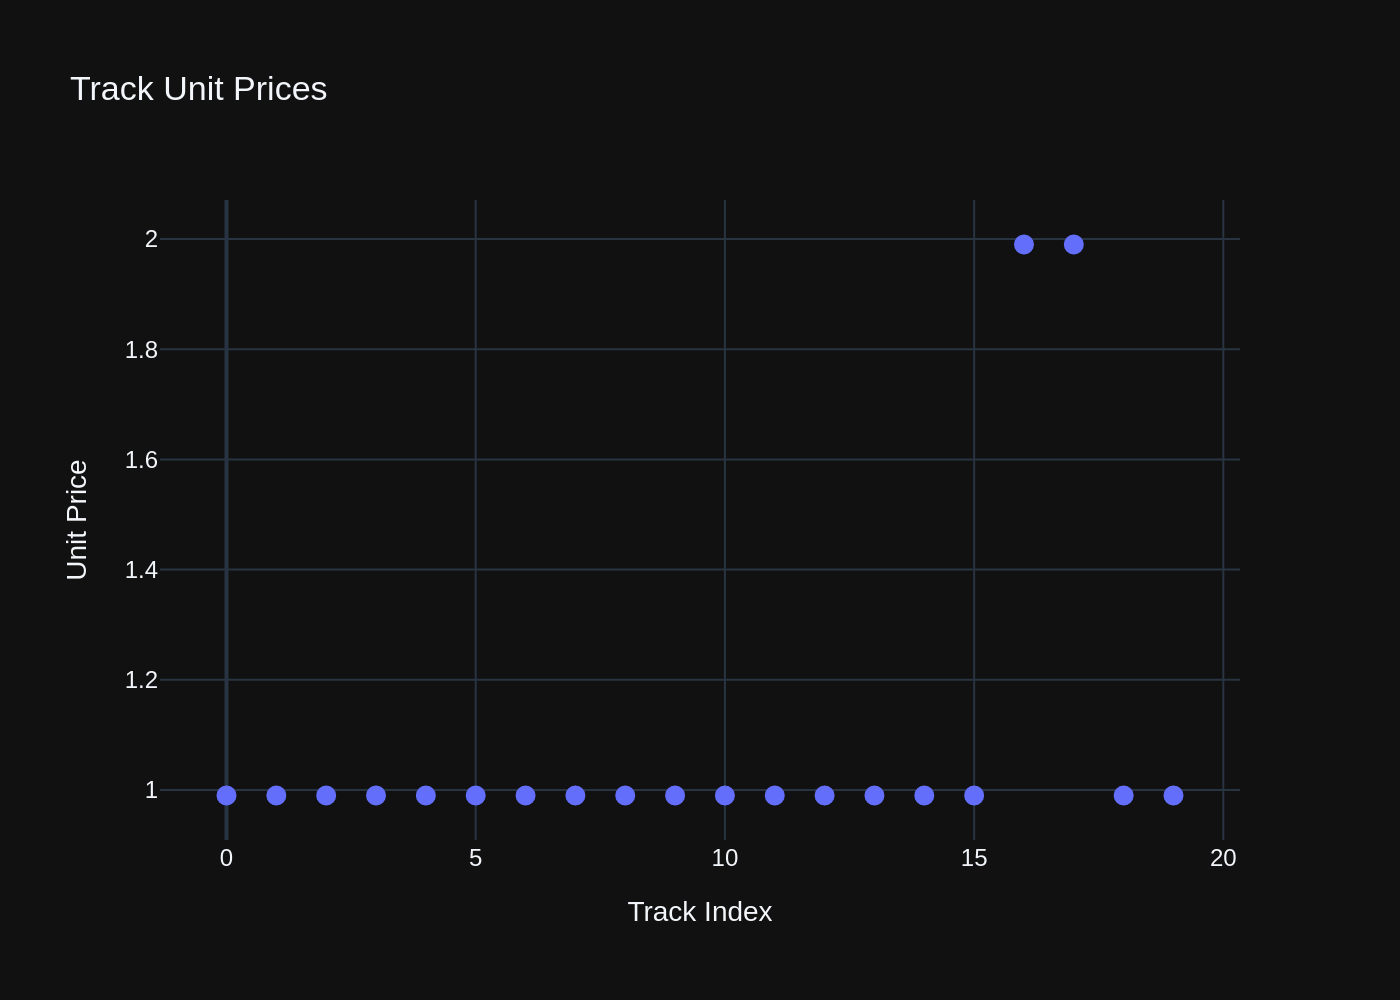





# QUESTION  - 8:  Get the total number of invoices for each customer


Using model claude-3-sonnet-20240229 for 865.25 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT c.CustomerId, c.FirstName, c.LastName, COUNT(i.InvoiceId) AS total_invoices
FROM customers c
LEFT JOIN invoices i ON c.CustomerId = i.CustomerId
GROUP BY c.CustomerId
ORDER BY total_invoices DESC
LIMIT 20


[( <DataFrame> )]
queried dataframe



,CustomerId,FirstName,LastName,total_invoices
0,1,Luís,Gonçalves,7
1,2,Leonie,Köhler,7
2,3,François,Tremblay,7
3,4,Bjørn,Hansen,7
4,5,František,Wichterlová,7
5,6,Helena,Holý,7
6,7,Astrid,Gruber,7
7,8,Daan,Peeters,7
8,9,Kara,Nielsen,7
9,10,Eduardo,Martins,7


Using model claude-3-sonnet-20240229 for 230.25 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objs as go
import pandas as pd

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number+delta",
        value=df['total_invoices'].values[0],
        title={"text": f"{df['FirstName'].values[0]} {df['LastName'].values[0]}"},
        domain={'x': [0, 1], 'y': [0, 1]}
    ))
else:
    fig = go.Figure(data=[go.Bar(
        x=df['FirstName'] + ' ' + df['LastName'],
        y=df['total_invoices'],
        text=df['total_invoices']
    )])
    fig.update_layout(
        xaxis_title="Customer",
        yaxis_title="Total Invoices",
        title="Total Invoices per Customer"
    )

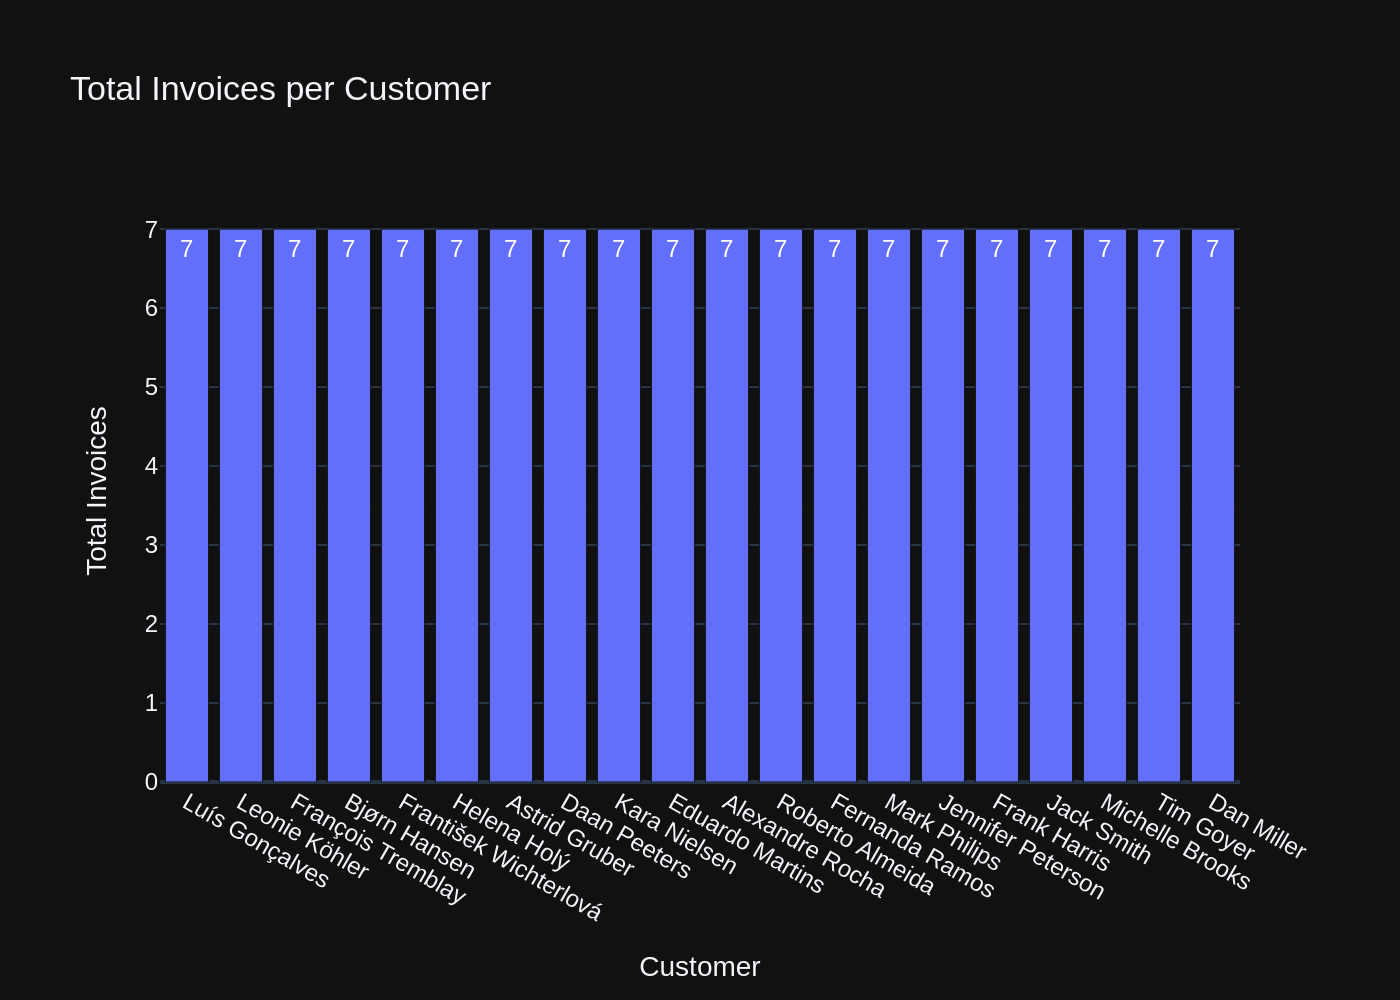





# QUESTION  - 9:  Find the total number of invoices per country


Using model claude-3-sonnet-20240229 for 935.5 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT BillingCountry, COUNT(*) AS total_invoices
FROM invoices
GROUP BY BillingCountry
ORDER BY total_invoices DESC
LIMIT 20


[( <DataFrame> )]
queried dataframe



,BillingCountry,total_invoices
0,USA,91
1,Canada,56
2,France,35
3,Brazil,35
4,Germany,28
5,United Kingdom,21
6,Portugal,14
7,Czech Republic,14
8,India,13
9,Sweden,7


Using model claude-3-sonnet-20240229 for 195.0 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objs as go

if len(df) == 1:
    value = df['total_invoices'].values[0]
    fig = go.Figure(go.Indicator(
        mode="number+delta",
        value=value,
        number={'prefix': "Total Invoices: "}
    ))
else:
    fig = go.Figure([go.Bar(x=df['BillingCountry'], y=df['total_invoices'])])

    fig.update_layout(
        title="Total Invoices per Country",
        xaxis_title="Country",
        yaxis_title="Total Invoices",
        barmode='group'
    )

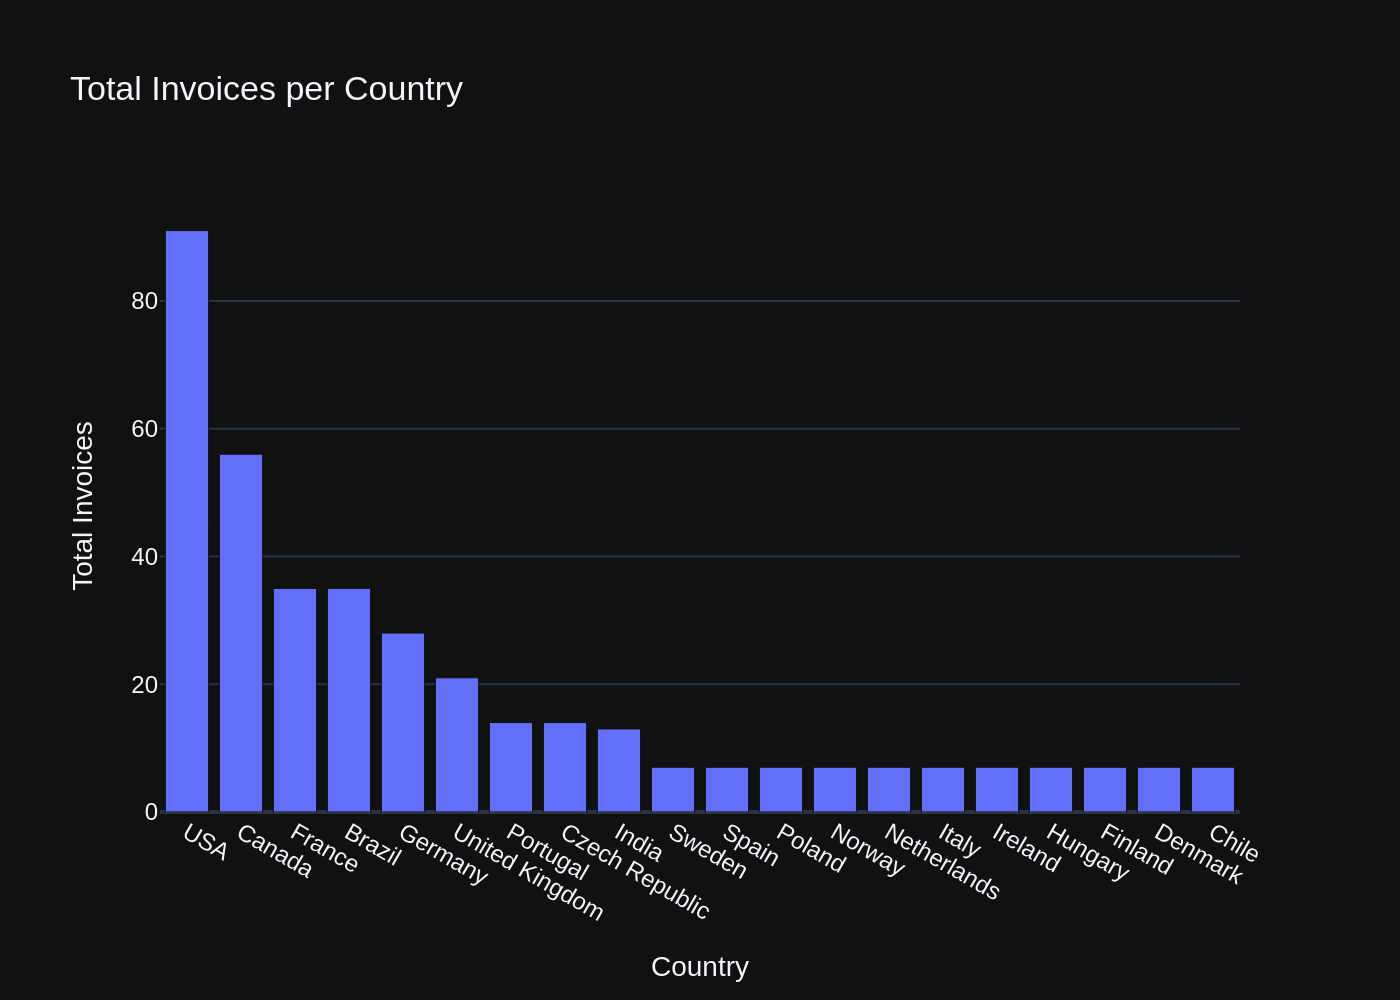





# QUESTION  - 10:  List all invoices with a total exceeding $10


Using model claude-3-sonnet-20240229 for 977.75 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT *
FROM invoices
WHERE Total > 10
ORDER BY Total DESC
LIMIT 20


[( <DataFrame> )]
queried dataframe



,InvoiceId,CustomerId,InvoiceDate,BillingAddress,BillingCity,BillingState,BillingCountry,BillingPostalCode,Total
0,404,6,2013-11-13 00:00:00,Rilská 3174/6,Prague,None,Czech Republic,14300,25.86
1,299,26,2012-08-05 00:00:00,2211 W Berry Street,Fort Worth,TX,USA,76110,23.86
2,96,45,2010-02-18 00:00:00,Erzsébet krt. 58.,Budapest,None,Hungary,H-1073,21.86
3,194,46,2011-04-28 00:00:00,3 Chatham Street,Dublin,Dublin,Ireland,None,21.86
4,89,7,2010-01-18 00:00:00,"Rotenturmstraße 4, 1010 Innere Stadt",Vienne,None,Austria,1010,18.86
5,201,25,2011-05-29 00:00:00,319 N. Frances Street,Madison,WI,USA,53703,18.86
6,88,57,2010-01-13 00:00:00,"Calle Lira, 198",Santiago,None,Chile,None,17.91
7,306,5,2012-09-05 00:00:00,Klanova 9/506,Prague,None,Czech Republic,14700,16.86
8,313,43,2012-10-06 00:00:00,"68, Rue Jouvence",Dijon,None,France,21000,16.86
9,103,24,2010-03-21 00:00:00,162 E Superior Street,Chicago,IL,USA,60611,15.86


Using model claude-3-sonnet-20240229 for 233.25 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number+delta",
        value=df['Total'].values[0],
        title={"text": "Total"}
    ))
else:
    fig = go.Figure(data=[go.Bar(x=df['InvoiceId'], y=df['Total'])])
    fig.update_layout(
        title="Invoices with Total Exceeding $10",
        xaxis_title="Invoice ID",
        yaxis_title="Total"
    )

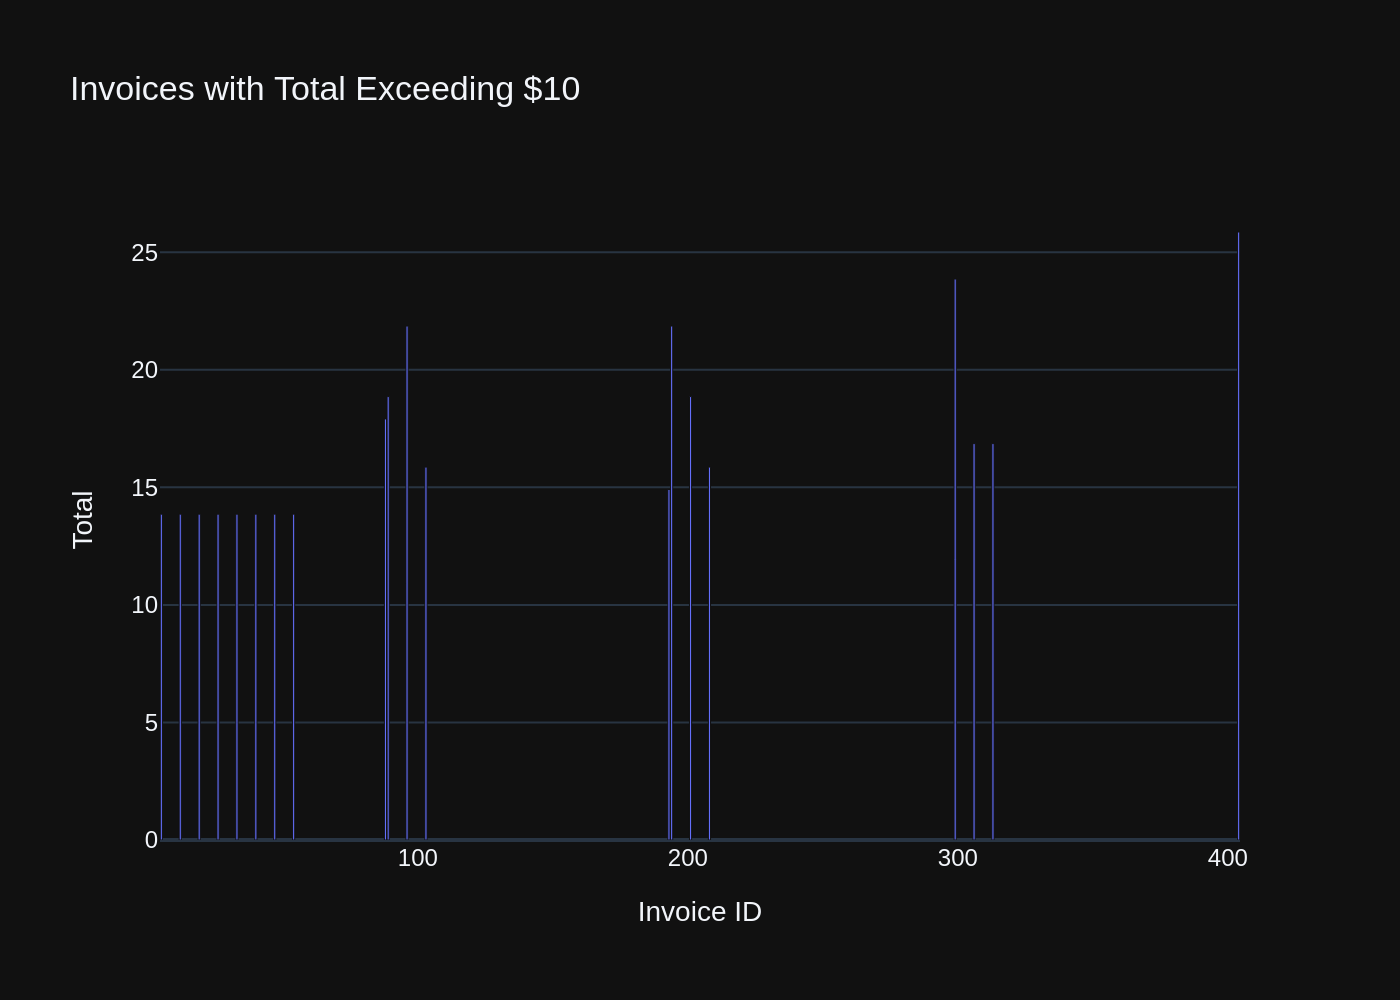





# QUESTION  - 11:  Find all invoices since 2010 and the total amount invoiced:


Using model claude-3-sonnet-20240229 for 1005.0 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT COUNT(*) AS num_invoices, SUM(Total) AS total_amount
FROM invoices
WHERE InvoiceDate >= '2010-01-01'
LIMIT 20


[( <DataFrame> )]
queried dataframe



,num_invoices,total_amount
0,329,1879.14


Using model claude-3-sonnet-20240229 for 195.75 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number+delta",
        value=df['total_amount'][0],
        number={'prefix': "$", 'valueformat': ',d'},
        delta={'relative': False, 'valueformat': ',d', 'reference': df['num_invoices'][0]},
        domain={'x': [0, 1], 'y': [0, 1]}
    ))
else:
    fig = go.Figure()
    fig.add_trace(go.Bar(x=df['num_invoices'], y=df['total_amount'], marker_color='indianred'))
    fig.update_layout(title='Invoices and Total Amount', xaxis_title='Number of Invoices', yaxis_title='Total Amount')

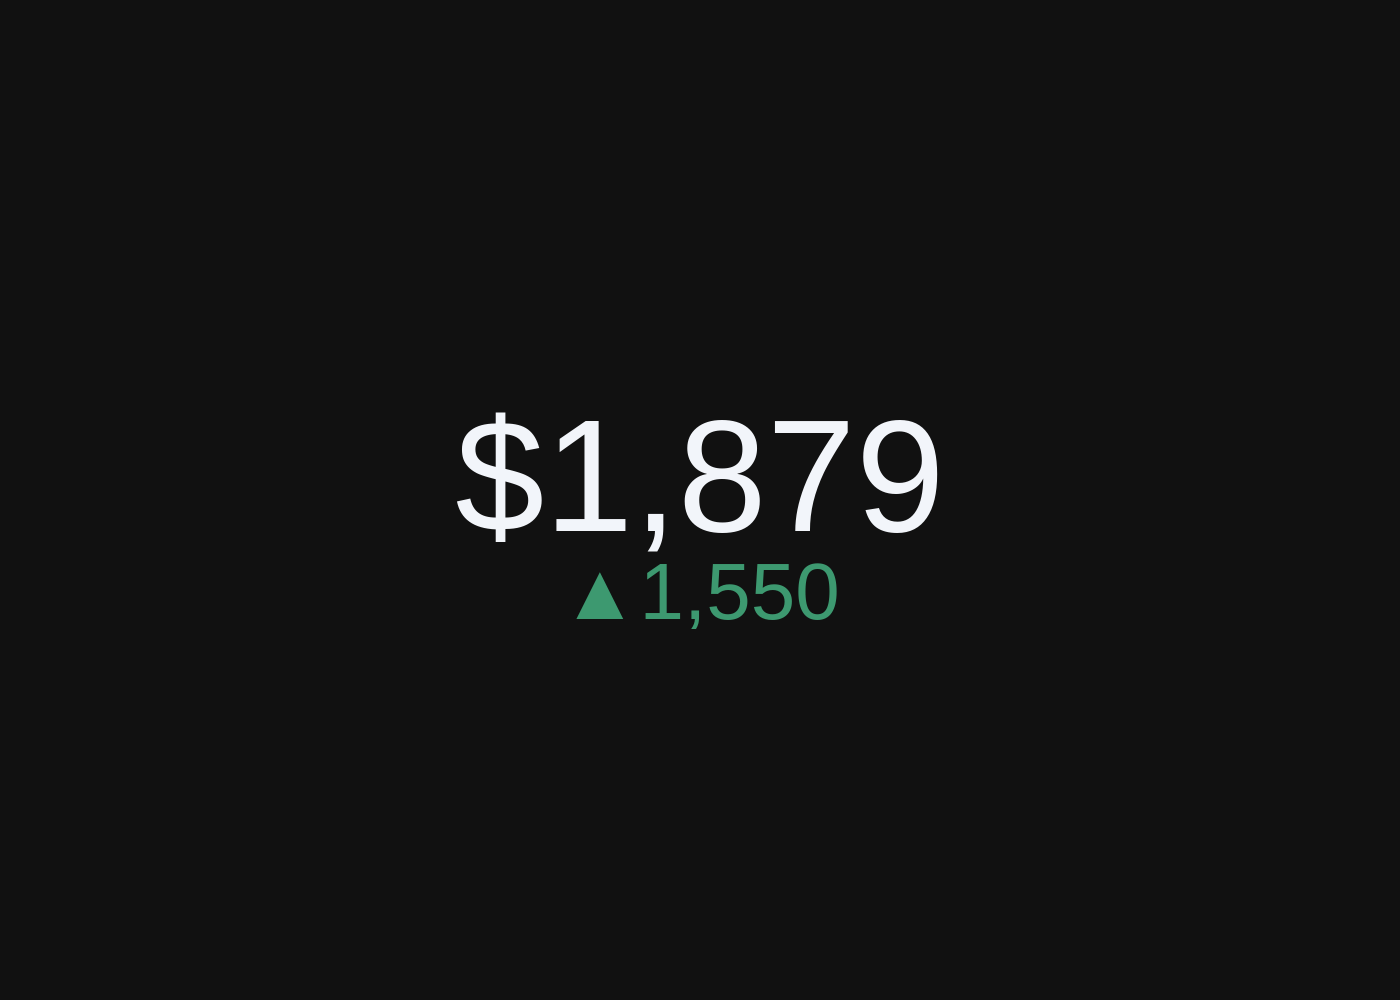





# QUESTION  - 12:  List all employees and their reporting manager's name (if any):


Using model claude-3-sonnet-20240229 for 1047.75 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT e.FirstName || ' ' || e.LastName AS Employee, 
       m.FirstName || ' ' || m.LastName AS Manager
FROM employees e
LEFT JOIN employees m ON e.ReportsTo = m.EmployeeId
ORDER BY Employee
LIMIT 20


[( <DataFrame> )]
queried dataframe



,Employee,Manager
0,Andrew Adams,None
1,Jane Peacock,Nancy Edwards
2,Laura Callahan,Michael Mitchell
3,Margaret Park,Nancy Edwards
4,Michael Mitchell,Andrew Adams
5,Nancy Edwards,Andrew Adams
6,Robert King,Michael Mitchell
7,Steve Johnson,Nancy Edwards


Using model claude-3-sonnet-20240229 for 215.25 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="gauge+number",
        value=df['Employee'].iloc[0],
        title={'text': "Employee"},
        domain={'x': [0, 1], 'y': [0, 1]}
    ))
else:
    fig = go.Figure(data=[go.Table(
        header=dict(values=list(df.columns),
                    fill_color='paleturquoise',
                    align='left'),
        cells=dict(values=[df[col] for col in df.columns],
                   fill_color='lavender',
                   align='left'))
    ])

fig.update_layout(title_text="Employees and Managers")

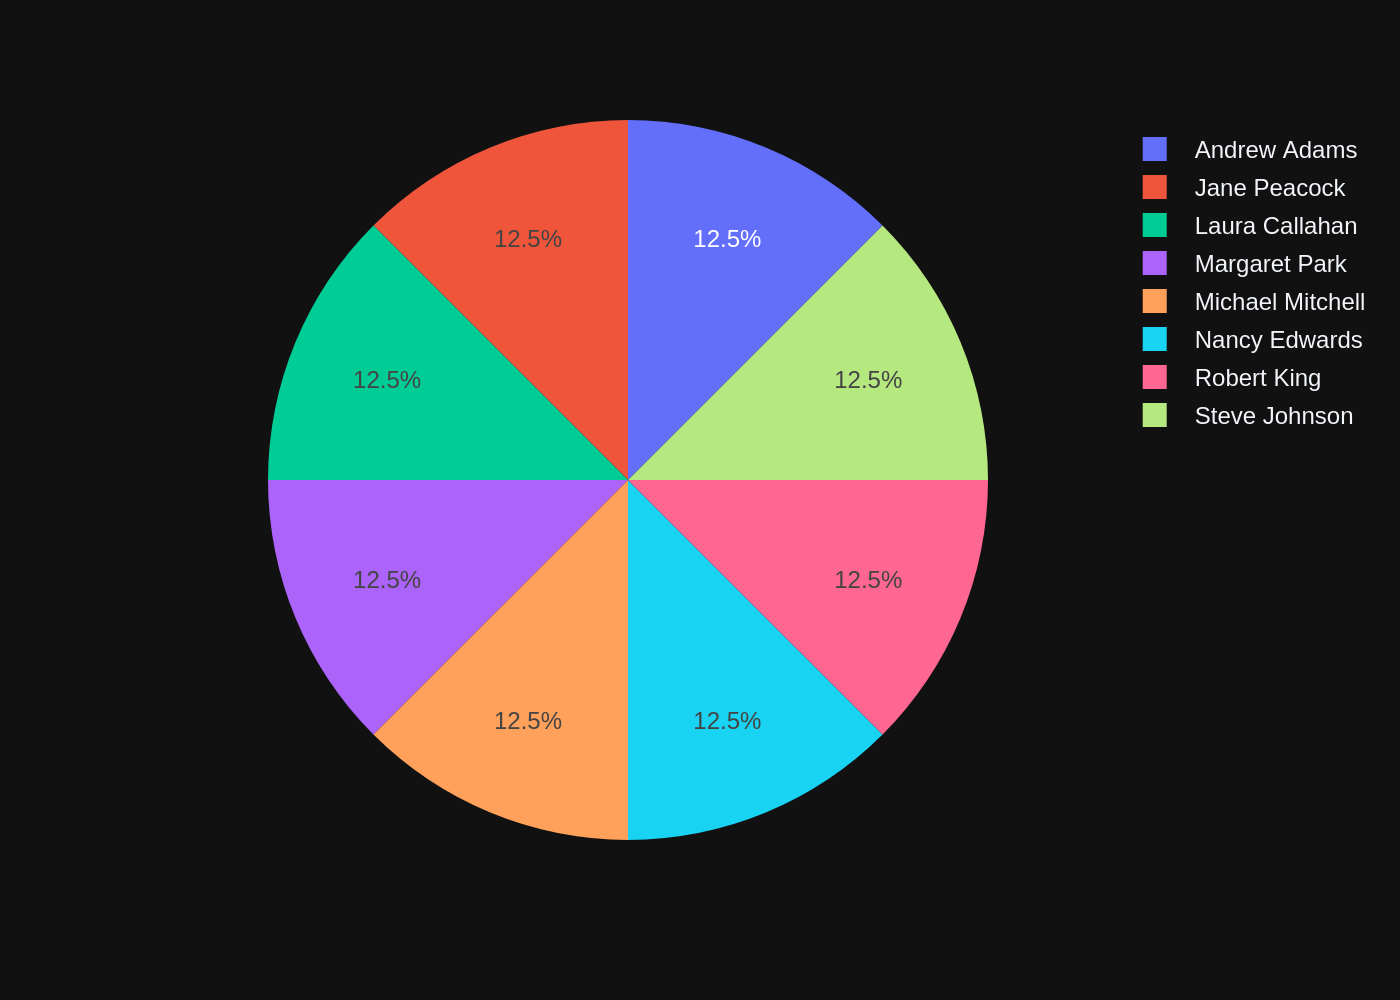





# QUESTION  - 13:   Get the average invoice total for each customer:


Using model claude-3-sonnet-20240229 for 1009.75 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT c.CustomerId, c.FirstName, c.LastName, AVG(i.Total) AS avg_invoice_total
FROM customers c
LEFT JOIN invoices i ON c.CustomerId = i.CustomerId  
GROUP BY c.CustomerId
ORDER BY avg_invoice_total DESC
LIMIT 20


[( <DataFrame> )]
queried dataframe



,CustomerId,FirstName,LastName,avg_invoice_total
0,6,Helena,Holý,7.088571
1,26,Richard,Cunningham,6.802857
2,57,Luis,Rojas,6.660000
3,45,Ladislav,Kovács,6.517143
4,46,Hugh,O'Reilly,6.517143
5,24,Frank,Ralston,6.231429
6,28,Julia,Barnett,6.231429
7,37,Fynn,Zimmermann,6.231429
8,59,Puja,Srivastava,6.106667
9,7,Astrid,Gruber,6.088571


Using model claude-3-sonnet-20240229 for 234.5 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="gauge+number",
        value=df['avg_invoice_total'].values[0],
        title={'text': "Average Invoice Total"}
    ))
else:
    fig = go.Figure(data=[go.Bar(
        x=df['FirstName'] + ' ' + df['LastName'],
        y=df['avg_invoice_total'],
        text=df['avg_invoice_total'],
        textposition='auto'
    )])
    fig.update_layout(
        title='Average Invoice Total by Customer',
        xaxis_title='Customer',
        yaxis_title='Average Invoice Total'
    )

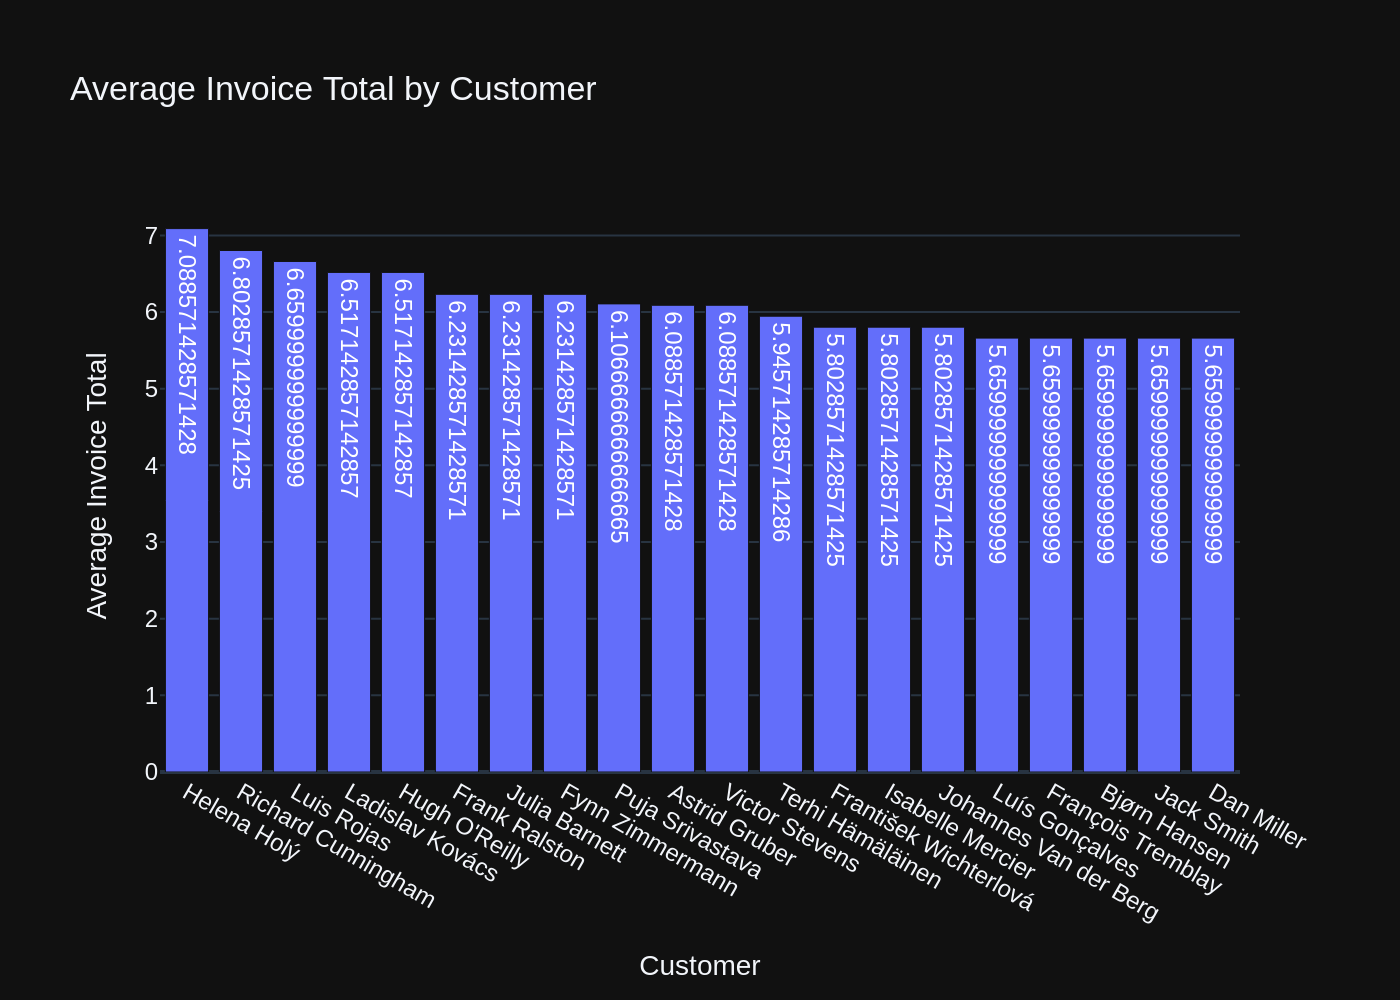





# QUESTION  - 14:  Find the top 5 most expensive tracks (based on unit price):


Using model claude-3-sonnet-20240229 for 1104.0 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT Name, UnitPrice 
FROM tracks
ORDER BY UnitPrice DESC
LIMIT 5


[( <DataFrame> )]
queried dataframe



,Name,UnitPrice
0,Battlestar Galactica: The Story So Far,1.99
1,Occupation / Precipice,1.99
2,"Exodus, Pt. 1",1.99
3,"Exodus, Pt. 2",1.99
4,Collaborators,1.99


Using model claude-3-sonnet-20240229 for 182.0 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number+delta",
        value=df['UnitPrice'].values[0],
        title={"text": df['Name'].values[0]}
    ))
else:
    fig = go.Figure(data=[go.Bar(x=df['Name'], y=df['UnitPrice'])])
    fig.update_layout(xaxis_title="Track Name", yaxis_title="Unit Price")

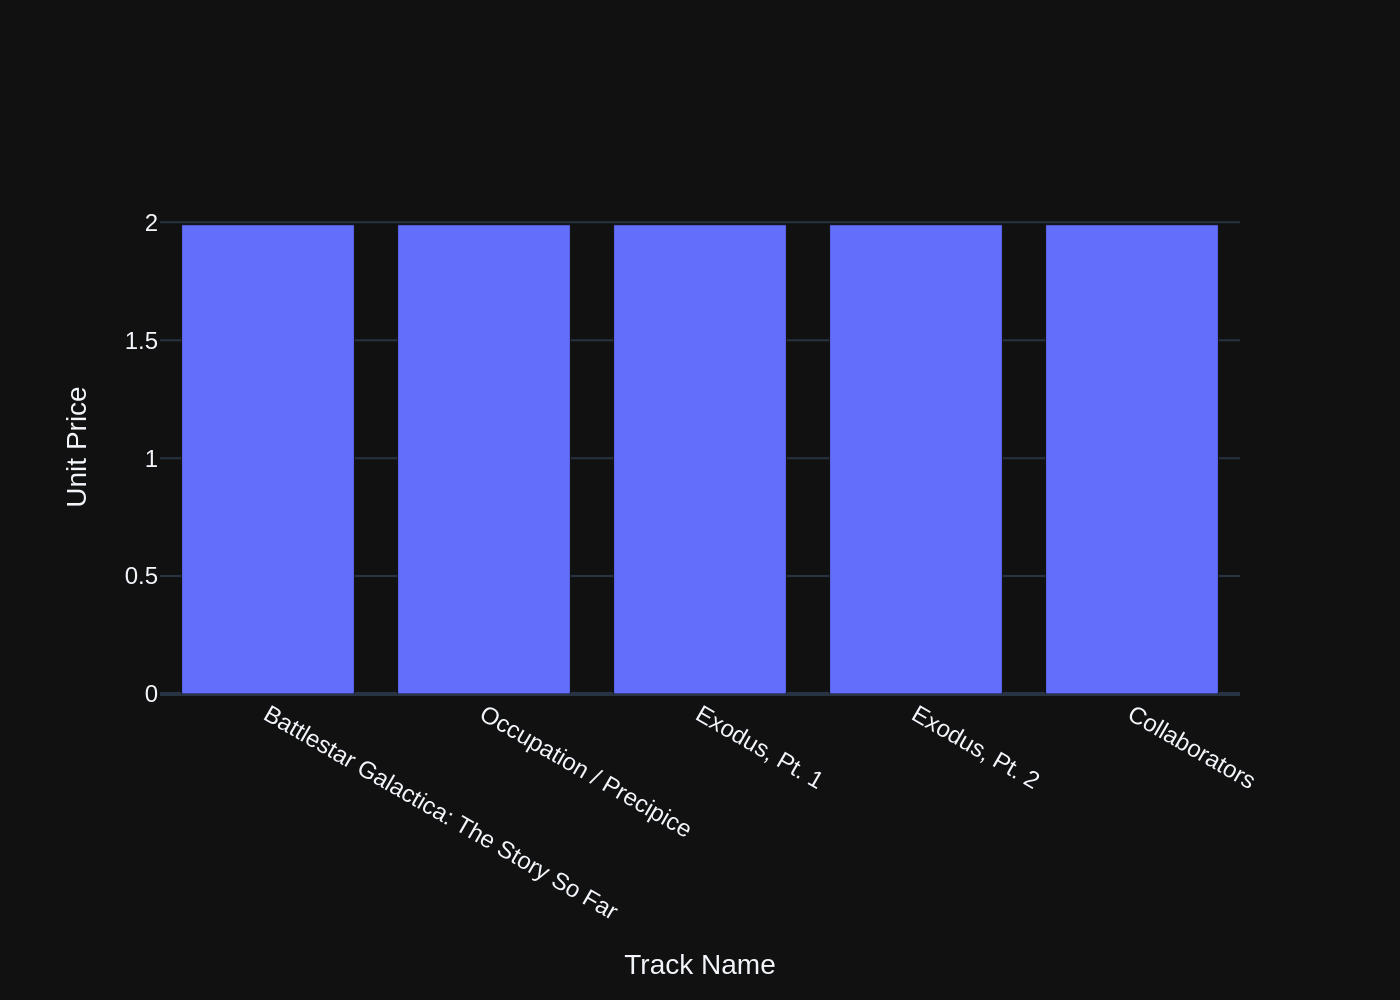





# QUESTION  - 15:  List all genres and the number of tracks in each genre:


Using model claude-3-sonnet-20240229 for 1079.75 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT g.Name AS Genre, COUNT(t.TrackId) AS NumTracks
FROM genres g
LEFT JOIN tracks t ON g.GenreId = t.GenreId
GROUP BY g.GenreId
ORDER BY NumTracks DESC
LIMIT 20


[( <DataFrame> )]
queried dataframe



,Genre,NumTracks
0,Rock,1297
1,Latin,579
2,Metal,374
3,Alternative & Punk,332
4,Jazz,130
5,TV Shows,93
6,Blues,81
7,Classical,74
8,Drama,64
9,R&B/Soul,61


Using model claude-3-sonnet-20240229 for 204.5 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number+delta",
        value=df['NumTracks'].values[0],
        title={"text": df['Genre'].values[0]}
    ))
else:
    fig = go.Figure(data=[go.Bar(x=df['Genre'], y=df['NumTracks'])])
    fig.update_layout(xaxis_title='Genre', yaxis_title='Number of Tracks')

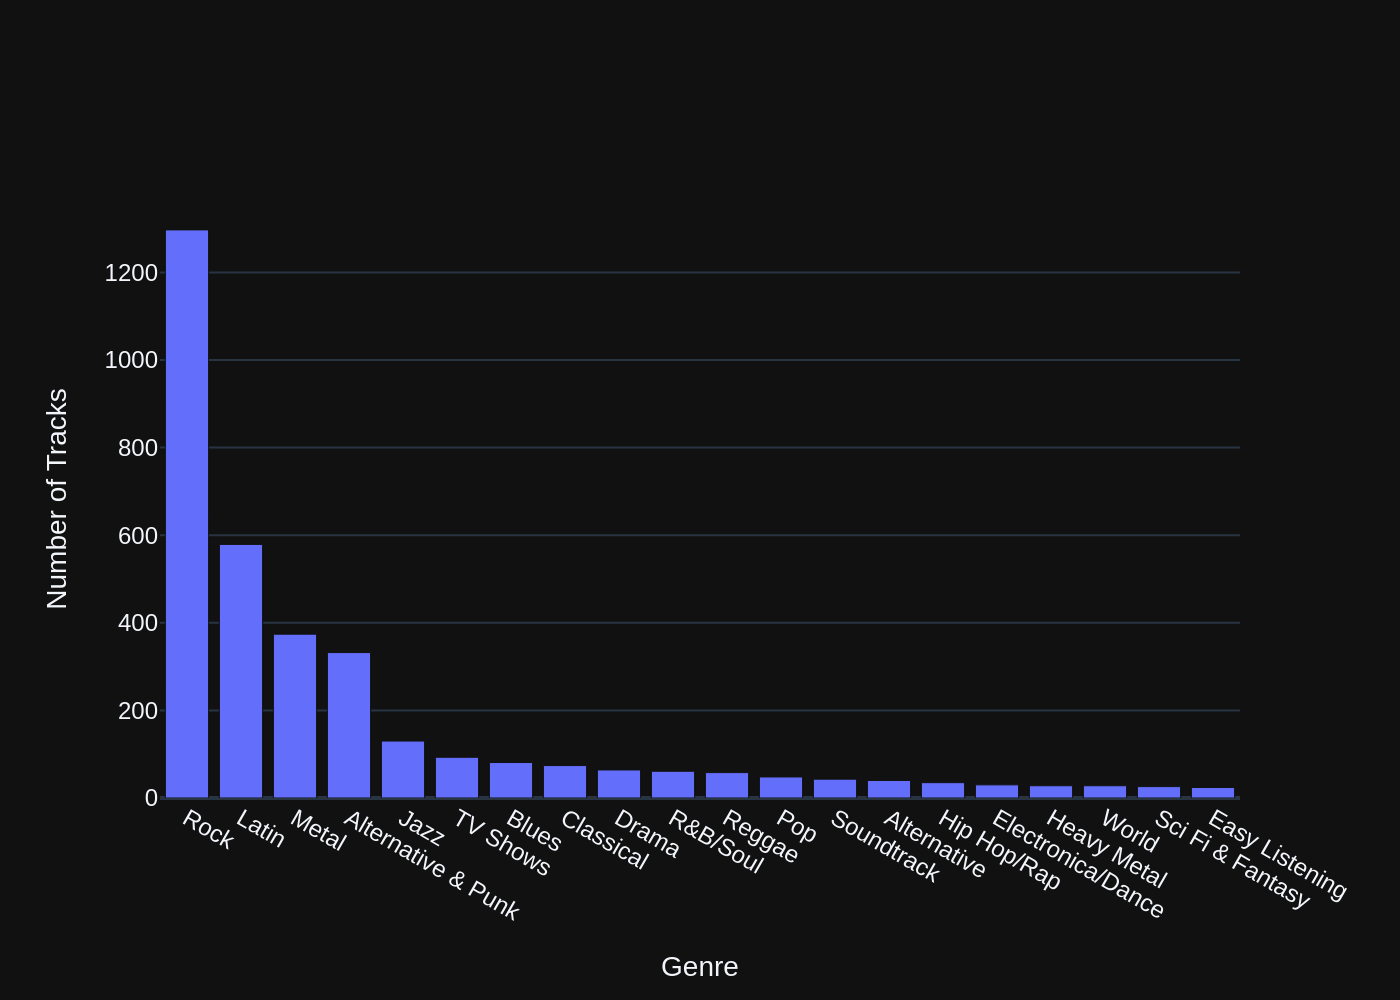





# QUESTION  - 16:  Get all genres that do not have any tracks associated with them:


Using model claude-3-sonnet-20240229 for 1090.5 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT g.Name
FROM genres g
LEFT JOIN tracks t ON g.GenreId = t.GenreId
WHERE t.TrackId IS NULL
GROUP BY g.GenreId
LIMIT 20


[( <DataFrame> )]
queried dataframe



,Name



[( RETRY )]
***** 1 *****

Using model claude-3-sonnet-20240229 for 1179.5 tokens (approx)

[( RETRY )]
***** 2 *****

Using model claude-3-sonnet-20240229 for 1160.0 tokens (approx)

[( RETRY )]
***** 3 *****

Using model claude-3-sonnet-20240229 for 1219.75 tokens (approx)

[( EXTRACTED SQL )]
with them. The "genres" and "tracks" tables need to be joined, and the query should filter for genres that have a null or 0 count of associated tracks.

Here is the SQL query to get all genres without any associated tracks:

SELECT g.Name AS Genre
FROM genres g
LEFT JOIN tracks t ON g.GenreId = t.GenreId
GROUP BY g.GenreId
HAVING COUNT(t.TrackId) = 0;


[( <SQL> )]
generated SQL statement



with them. The "genres" and "tracks" tables need to be joined, and the query should filter for genres that have a null or 0 count of associated tracks.

Here is the SQL query to get all genres without any associated tracks:

SELECT g.Name AS Genre
FROM genres g
LEFT JOIN tracks t ON g.GenreId = t.GenreId
GROUP BY g.GenreId
HAVING COUNT(t.TrackId) = 0;





# QUESTION  - 17:  List all customers who have not placed any orders:


Using model claude-3-sonnet-20240229 for 1142.0 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT c.*
FROM customers c
LEFT JOIN invoices i ON c.CustomerId = i.CustomerId
WHERE i.InvoiceId IS NULL
LIMIT 20


[( <DataFrame> )]
queried dataframe



,CustomerId,FirstName,LastName,Company,Address,City,State,Country,PostalCode,Phone,Fax,Email,SupportRepId



[( RETRY )]
***** 1 *****

Using model claude-3-sonnet-20240229 for 1220.5 tokens (approx)

[( RETRY )]
***** 2 *****

Using model claude-3-sonnet-20240229 for 1278.75 tokens (approx)

[( RETRY )]
***** 3 *****

Using model claude-3-sonnet-20240229 for 1338.5 tokens (approx)




# QUESTION  - 18:   
        Can you find the top 10 most popular artists based on the number of tracks?
        Hint: There are 3 tables - artists, albums and tracks, 
        where albums and artists are linked by ArtistId, albums and tracks are linked by AlbumId,
    


Using model claude-3-sonnet-20240229 for 1135.75 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT ar.Name AS Artist, COUNT(t.TrackId) AS NumTracks
FROM artists ar
JOIN albums a ON ar.ArtistId = a.ArtistId
JOIN tracks t ON a.AlbumId = t.AlbumId
GROUP BY ar.ArtistId
ORDER BY NumTracks DESC
LIMIT 10


[( <DataFrame> )]
queried dataframe



,Artist,NumTracks
0,Iron Maiden,213
1,U2,135
2,Led Zeppelin,114
3,Metallica,112
4,Deep Purple,92
5,Lost,92
6,Pearl Jam,67
7,Lenny Kravitz,57
8,Various Artists,56
9,The Office,53


Using model claude-3-sonnet-20240229 for 264.5 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number+delta",
        value=df['NumTracks'].values[0],
        title={"text": f"Number of Tracks for {df['Artist'].values[0]}"}
    ))
else:
    fig = go.Figure(data=[go.Bar(x=df['Artist'], y=df['NumTracks'])])
    fig.update_layout(
        title="Top 10 Most Popular Artists by Number of Tracks",
        xaxis_title="Artist",
        yaxis_title="Number of Tracks",
        barmode='group'
    )

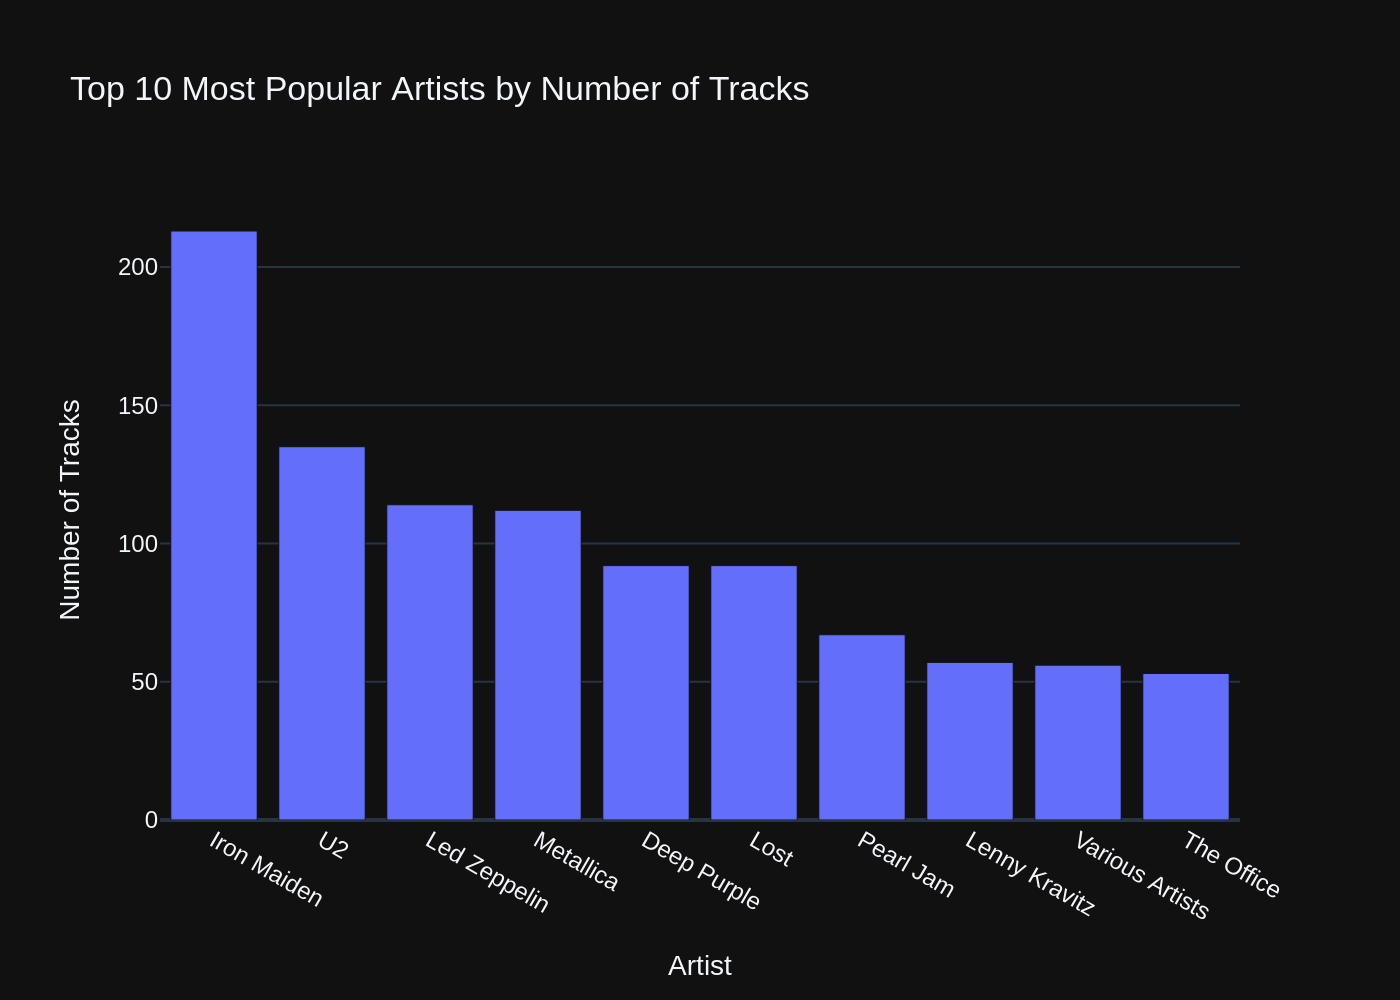





# QUESTION  - 19:  List all customers from Canada and their email addresses:


Using model claude-3-sonnet-20240229 for 1132.75 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT FirstName, LastName, Email
FROM customers
WHERE Country = 'Canada'
ORDER BY LastName
LIMIT 20


[( <DataFrame> )]
queried dataframe



,FirstName,LastName,Email
0,Robert,Brown,robbrown@shaw.ca
1,Edward,Francis,edfrancis@yachoo.ca
2,Aaron,Mitchell,aaronmitchell@yahoo.ca
3,Jennifer,Peterson,jenniferp@rogers.ca
4,Mark,Philips,mphilips12@shaw.ca
5,Martha,Silk,marthasilk@gmail.com
6,Ellie,Sullivan,ellie.sullivan@shaw.ca
7,François,Tremblay,ftremblay@gmail.com


Using model claude-3-sonnet-20240229 for 194.25 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number+delta",
        value=df.iloc[0]['FirstName'],
        delta={'reference': 0}))
else:
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df['LastName'], y=df['FirstName'], mode='markers', text=df['Email']))
    fig.update_layout(xaxis_title='Last Name', yaxis_title='First Name', hovermode='closest')

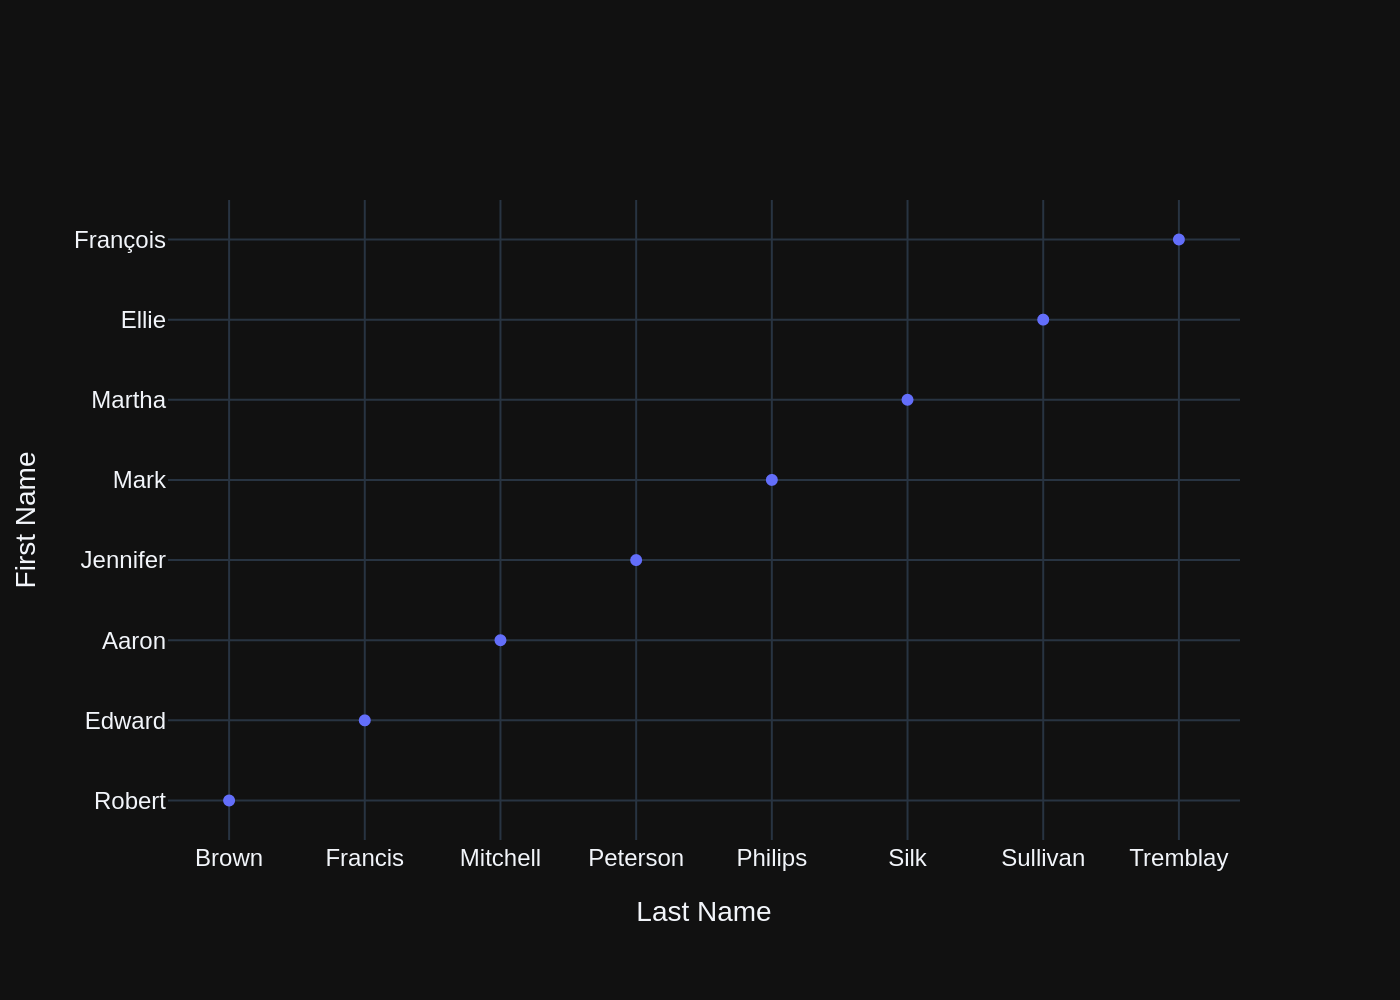





# QUESTION  - 20:  Find the customer with the most invoices 


Using model claude-3-sonnet-20240229 for 1185.25 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT c.CustomerId, c.FirstName, c.LastName, COUNT(i.InvoiceId) AS total_invoices  
FROM customers c
JOIN invoices i ON c.CustomerId = i.CustomerId
GROUP BY c.CustomerId
ORDER BY total_invoices DESC
LIMIT 1


[( <DataFrame> )]
queried dataframe



,CustomerId,FirstName,LastName,total_invoices
0,1,Luís,Gonçalves,7


Using model claude-3-sonnet-20240229 for 227.0 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number+delta",
        value=df['total_invoices'].values[0],
        title={"text": f"{df['FirstName'].values[0]} {df['LastName'].values[0]}"},
        delta={'reference': 0}
    ))
else:
    fig = go.Figure(data=[go.Bar(x=df['FirstName'] + ' ' + df['LastName'], y=df['total_invoices'])])
    fig.update_layout(title='Customers with Most Invoices', xaxis_title='Customer', yaxis_title='Total Invoices')

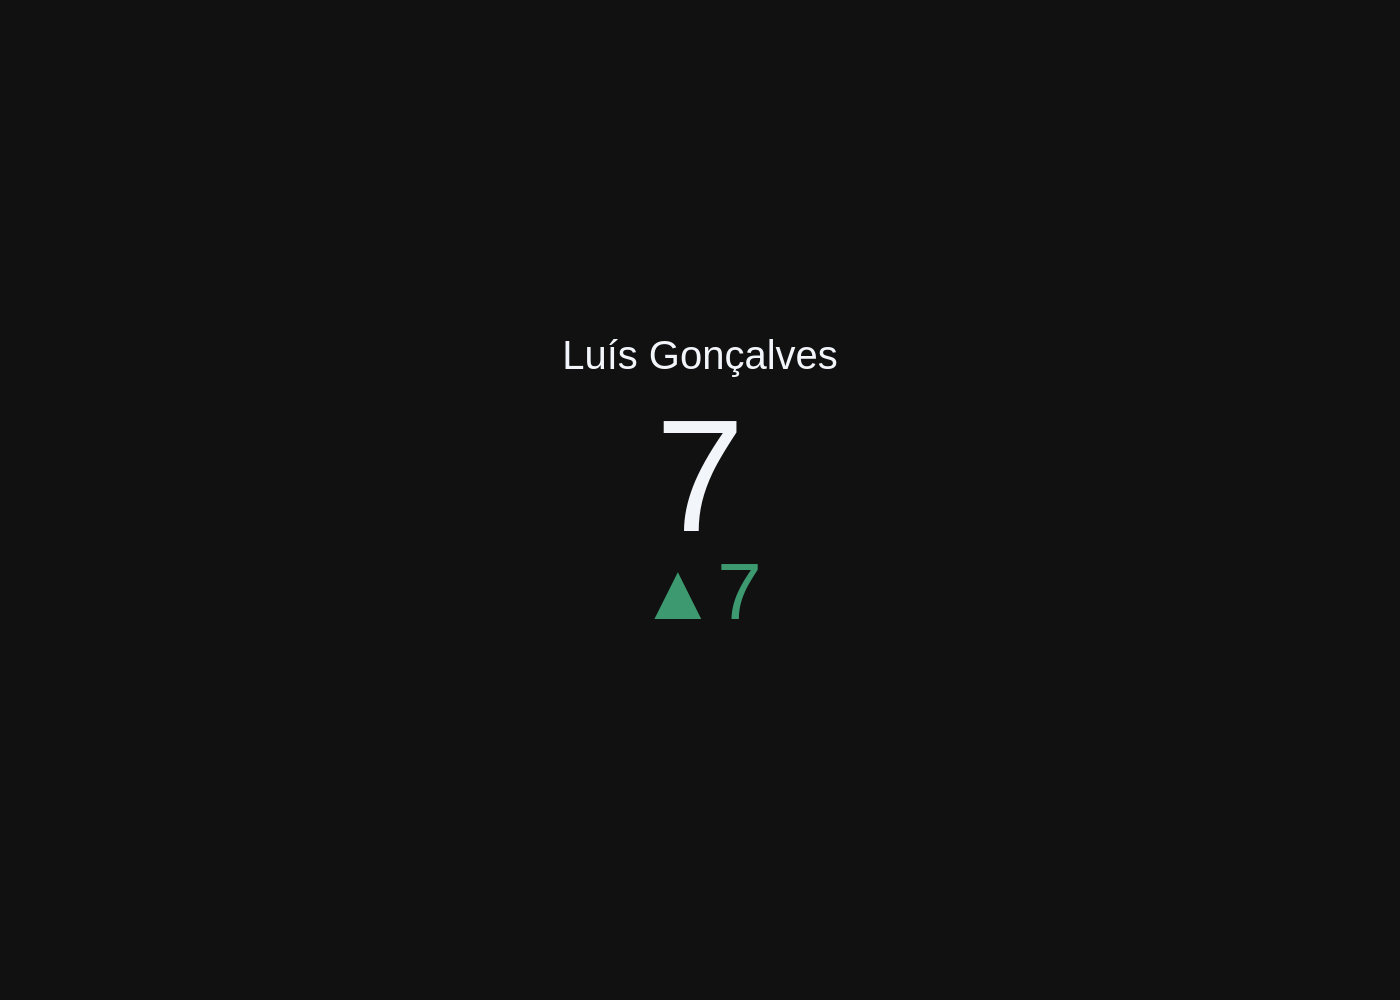





# QUESTION  - 21:  Find the customer who bought the most albums in total quantity (across all invoices):


Using model claude-3-sonnet-20240229 for 1267.25 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT c.CustomerId, c.FirstName, c.LastName, SUM(ii.Quantity) AS total_albums
FROM customers c
JOIN invoices i ON c.CustomerId = i.CustomerId
JOIN invoice_items ii ON i.InvoiceId = ii.InvoiceId
JOIN tracks t ON ii.TrackId = t.TrackId
JOIN albums a ON t.AlbumId = a.AlbumId
GROUP BY c.CustomerId
ORDER BY total_albums DESC
LIMIT 1


[( <DataFrame> )]
queried dataframe



,CustomerId,FirstName,LastName,total_albums
0,1,Luís,Gonçalves,38


Using model claude-3-sonnet-20240229 for 266.75 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number+delta",
        value=df['total_albums'].values[0],
        title={"text": f"{df['FirstName'].values[0]} {df['LastName'].values[0]}"},
        delta={'reference': 0}
    ))
else:
    fig = go.Figure(data=[
        go.Bar(
            x=df['FirstName'] + ' ' + df['LastName'],
            y=df['total_albums'],
            text=df['total_albums']
        )
    ])
    fig.update_layout(
        title="Total Albums Purchased by Customer",
        xaxis_title="Customer Name",
        yaxis_title="Total Albums Purchased"
    )

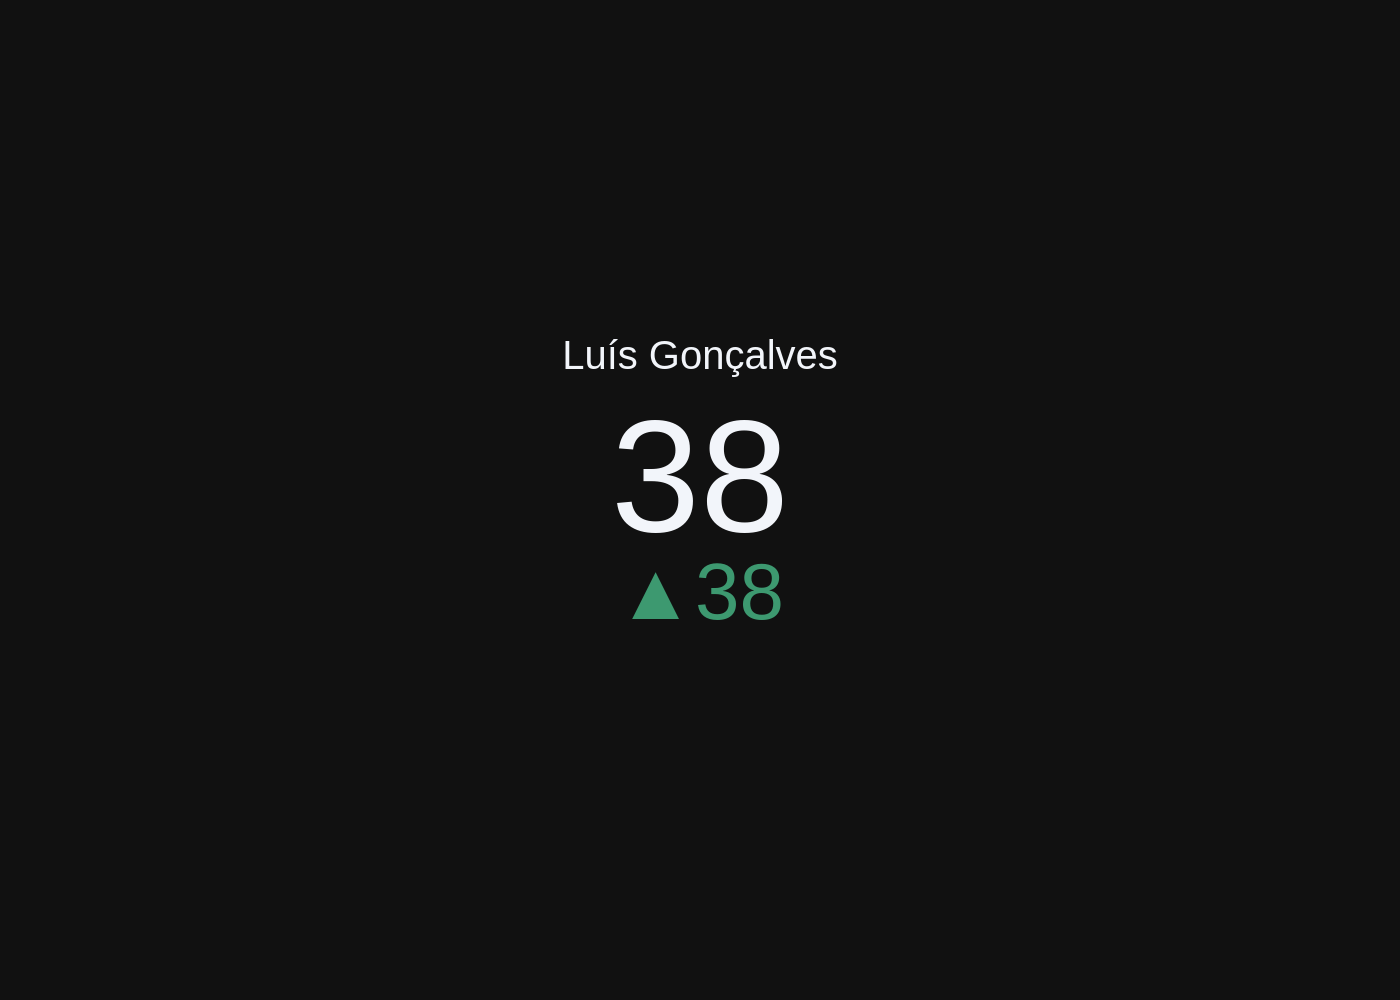





# QUESTION  - 22:        
        Find the top 5 customers who bought the most albums in total quantity (across all invoices):
        Hint: album quantity is found in invoice_items, 
    


Using model claude-3-sonnet-20240229 for 1337.5 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT c.CustomerId, c.FirstName, c.LastName, SUM(ii.Quantity) AS total_albums
FROM customers c
JOIN invoices i ON c.CustomerId = i.CustomerId
JOIN invoice_items ii ON i.InvoiceId = ii.InvoiceId
JOIN tracks t ON ii.TrackId = t.TrackId
JOIN albums a ON t.AlbumId = a.AlbumId
GROUP BY c.CustomerId
ORDER BY total_albums DESC
LIMIT 5


[( <DataFrame> )]
queried dataframe



,CustomerId,FirstName,LastName,total_albums
0,1,Luís,Gonçalves,38
1,2,Leonie,Köhler,38
2,3,François,Tremblay,38
3,4,Bjørn,Hansen,38
4,5,František,Wichterlová,38


Using model claude-3-sonnet-20240229 for 287.75 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number+delta",
        value=df['total_albums'].values[0],
        title={"text": f"{df['FirstName'].values[0]} {df['LastName'].values[0]}"},
        delta={'reference': 0}
    ))
else:
    fig = go.Figure(data=[
        go.Bar(
            x=df['FirstName'] + ' ' + df['LastName'],
            y=df['total_albums'],
            text=df['total_albums'],
            textposition='auto'
        )
    ])
    fig.update_layout(
        title='Top 5 Customers by Total Albums Purchased',
        xaxis_title='Customer Name',
        yaxis_title='Total Albums Purchased'
    )

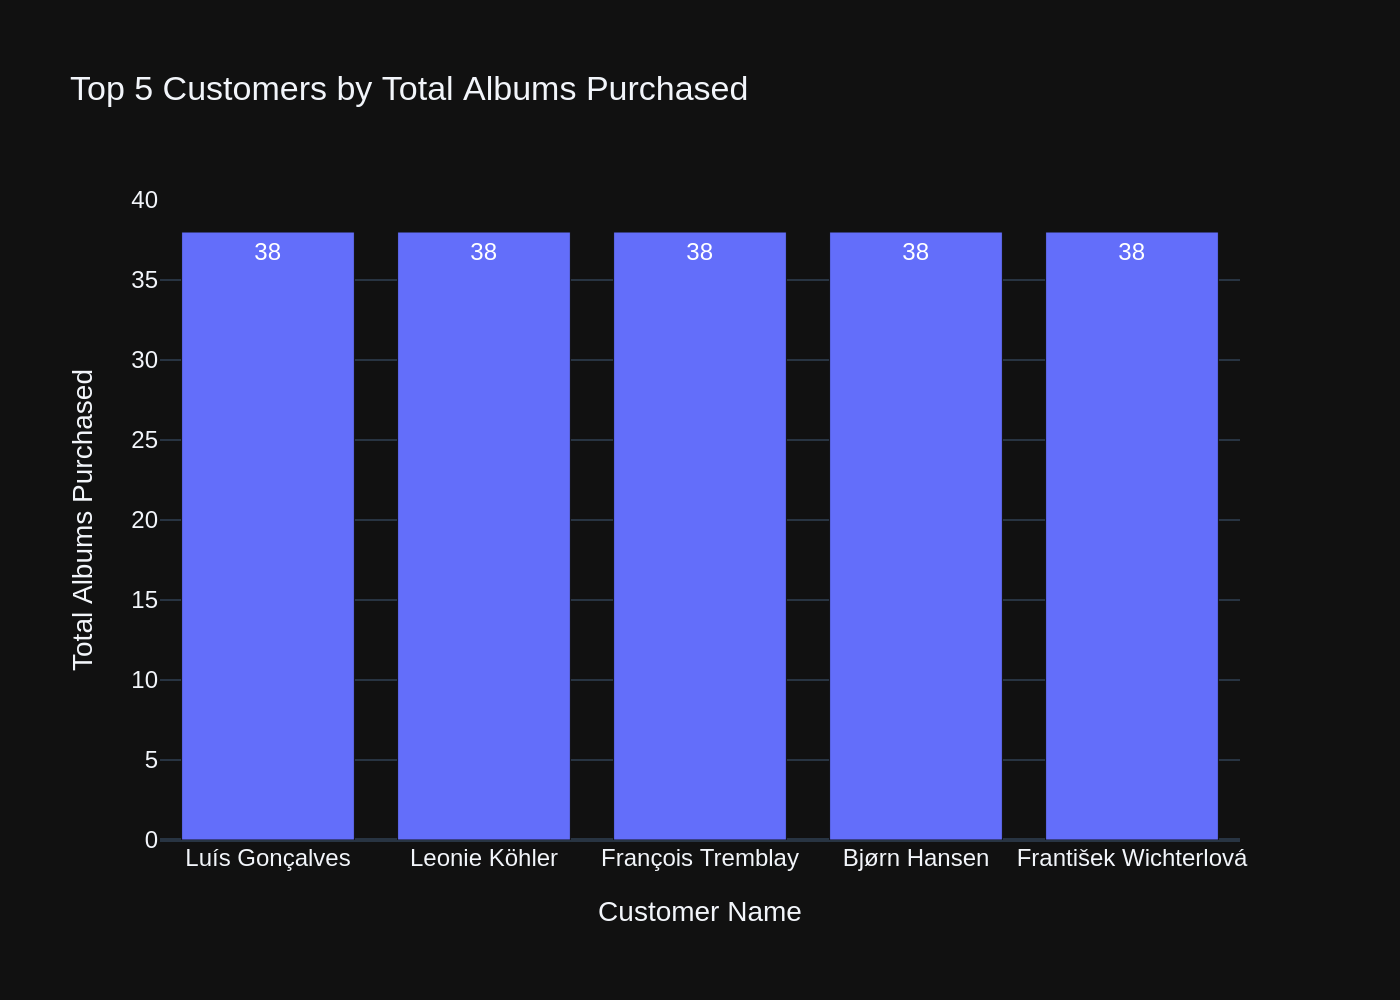





# QUESTION  - 23:    
         Find the top 5 customers who spent the most money overall,  
         Hint: order total can be found on invoices table, calculation using invoice_items detail table is unnecessary 
    


Using model claude-3-sonnet-20240229 for 1342.75 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT c.CustomerId, c.FirstName, c.LastName, SUM(i.Total) AS total_spent
FROM customers c
JOIN invoices i ON c.CustomerId = i.CustomerId
GROUP BY c.CustomerId
ORDER BY total_spent DESC
LIMIT 5


[( <DataFrame> )]
queried dataframe



,CustomerId,FirstName,LastName,total_spent
0,6,Helena,Holý,49.62
1,26,Richard,Cunningham,47.62
2,57,Luis,Rojas,46.62
3,45,Ladislav,Kovács,45.62
4,46,Hugh,O'Reilly,45.62


Using model claude-3-sonnet-20240229 for 260.5 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number+delta",
        value=df['total_spent'].values[0],
        title={"text": f"{df['FirstName'].values[0]} {df['LastName'].values[0]}"},
        delta={'reference': 0}
    ))
else:
    fig = go.Figure(data=[go.Bar(
        x=df['FirstName'] + ' ' + df['LastName'],
        y=df['total_spent'],
        text=df['total_spent'],
        textposition='auto'
    )])
    fig.update_layout(
        title=f"Top {len(df)} Customers by Total Spent",
        xaxis_title="Customer Name",
        yaxis_title="Total Spent ($)",
        bargap=0.1
    )

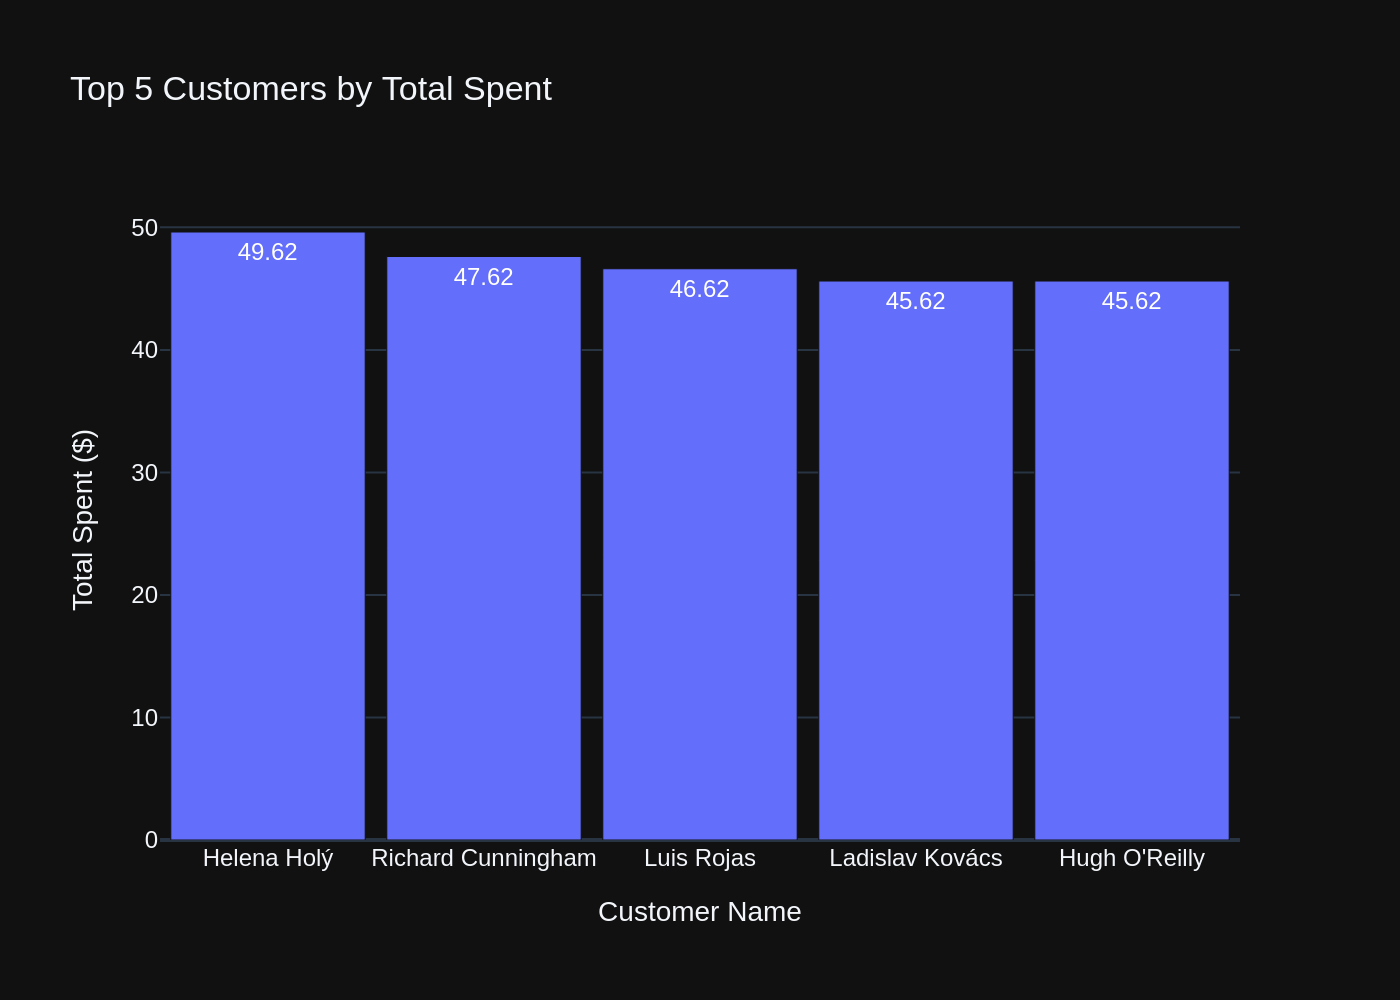





# QUESTION  - 24:  Get all playlists containing at least 10 tracks and the total duration of those tracks:


Using model claude-3-sonnet-20240229 for 1317.25 tokens (approx)

[( RETRY )]
***** 1 *****

Using model claude-3-sonnet-20240229 for 1574.5 tokens (approx)

[( RETRY )]
***** 2 *****

Using model claude-3-sonnet-20240229 for 1779.25 tokens (approx)

[( RETRY )]
***** 3 *****

Using model claude-3-sonnet-20240229 for 2023.75 tokens (approx)




# QUESTION  - 25:  Identify artists who have albums with tracks appearing in multiple genres:


Using model claude-3-sonnet-20240229 for 1275.5 tokens (approx)

[( RETRY )]
***** 1 *****

Using model claude-3-sonnet-20240229 for 1493.75 tokens (approx)

[( RETRY )]
***** 2 *****

Using model claude-3-sonnet-20240229 for 1671.5 tokens (approx)

[( RETRY )]
***** 3 *****

Using model claude-3-sonnet-20240229 for 1839.25 tokens (approx)

[( EXTRACTED SQL )]
SELECT ar.Name AS Artist
FROM artists ar
JOIN albums a ON ar.ArtistId = a.ArtistI

SELECT ar.Name AS Artist
FROM artists ar
JOIN albums a ON ar.ArtistId = a.ArtistId
JOIN tracks t ON a.AlbumId = t.AlbumId
JOIN genres g ON t.GenreId = g.GenreId
GROUP BY ar.ArtistId
HAVING COUNT(DISTINCT g.GenreId) > 1
LIMIT 20;


[( <DataFrame> )]
queried dataframe



,Artist
0,Antônio Carlos Jobim
1,Audioslave
2,Various Artists
3,Gilberto Gil
4,Eric Clapton
5,Faith No More
6,Foo Fighters
7,Guns N' Roses
8,Iron Maiden
9,Jamiroquai


Using model claude-3-sonnet-20240229 for 723.0 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['Artist'].values[0]
    ))
else:
    fig = go.Figure(data=[go.Bar(x=df.index, y=df['Artist'])])

fig.update_layout(
    title="Artists with Albums in Multiple Genres",
    xaxis_title="Artist",
    yaxis_title="Count"
)

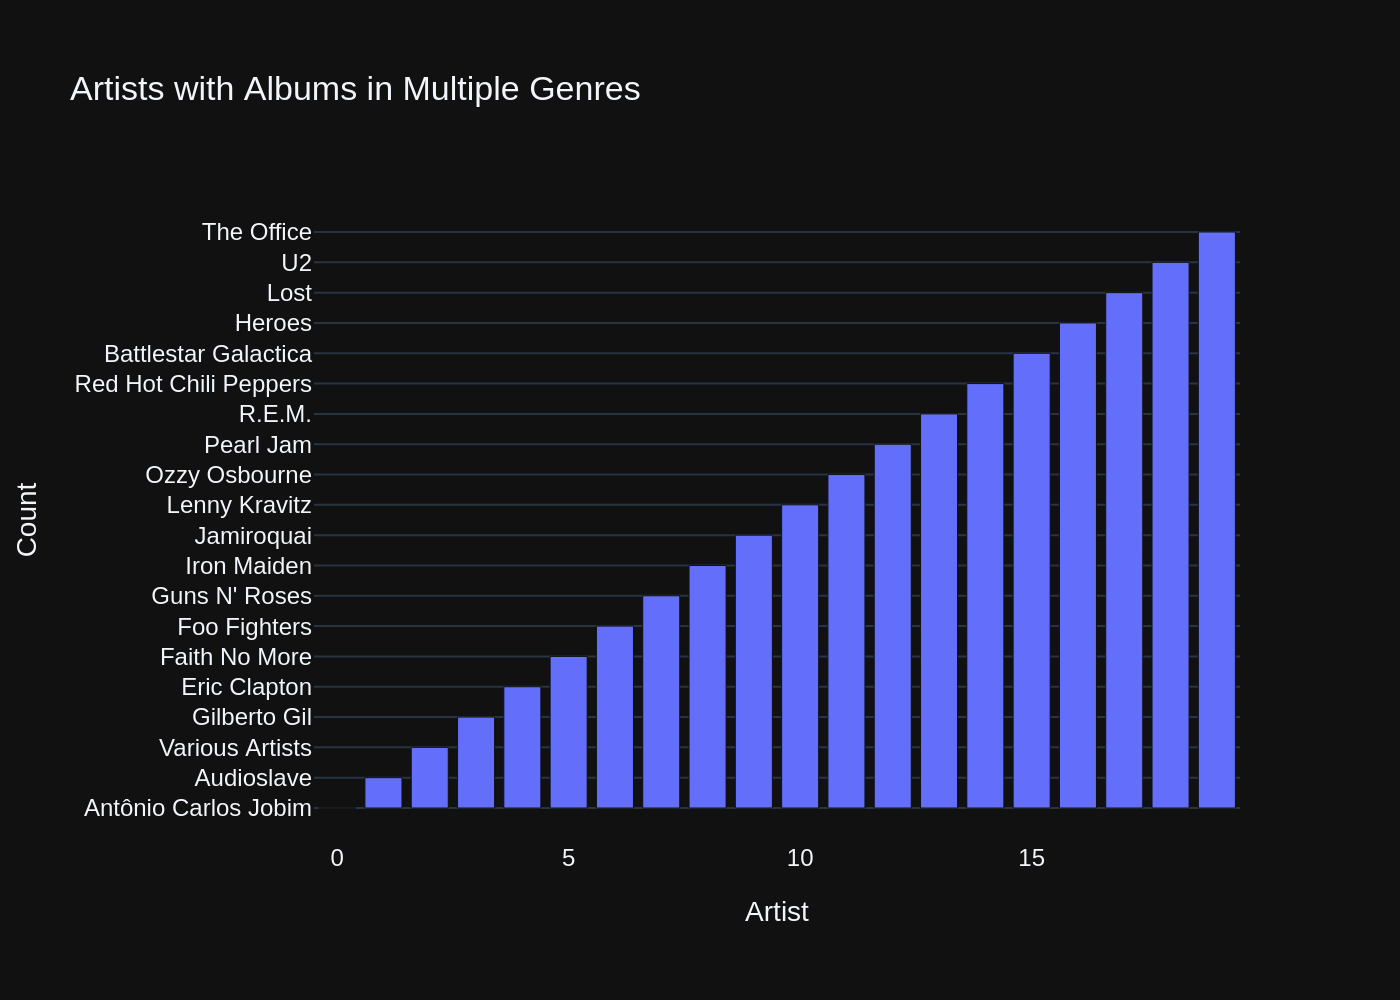

In [18]:
ts_start = time()
for n, question in enumerate(questions):
    # if n != 4: continue
    # if n > 5: continue

    resp = vn.ask_adaptive(question=question, tag_id=n+2)
    # vn.ask(question=question, allow_llm_to_see_data=allow_llm_to_see_data)
    # my_vn_ask(question=question, sql_id=n+2, allow_llm_to_see_data=allow_llm_to_see_data)

ts_stop = time()
elapsed_time = ts_stop - ts_start

## Check completion time

In [19]:
str_elapsed_sec = f"{elapsed_time:.0f}"
ts = datetime.now().strftime("%Y%m%d-%H%M%S")
print(f"Completed testing:\n================\n LLM model '{model_name}' \n took {str_elapsed_sec} sec\n run on '{hostname}' \n at {ts}")

Completed testing:
 LLM model 'claude-3-sonnet-20240229' 
 took 165 sec
 run on 'ducklover1' 
 at 20241122-233039


In [20]:
file_csv = f"training_data-{model_name}-{str_elapsed_sec}s-{hostname}-{ts}.csv"
file_csv

'training_data-claude-3-sonnet-20240229-165s-ducklover1-20241122-233039.csv'

### Save training data

In [21]:
# show training data
df_training_data = vn.get_training_data()
df_training_data

,id,question,content,training_data_type
0,09b5c84c-abca-5731-af61-7d148c5bd42f-sql,Can you list all tables in the SQLite database...,SELECT name FROM sqlite_master WHERE type='tab...,sql
1,13b1d5ca-868b-599f-acb0-3828a7d73b08-sql,what are the top 5 countries that customers co...,"SELECT Country, COUNT(*) AS num_customers\nFRO...",sql
2,2de3d2b1-76ba-5e17-9dc2-4a5338d28f82-sql,Find the total number of invoices per country,"SELECT BillingCountry, COUNT(*) AS total_invoi...",sql
3,31167446-8e8b-513c-b4ed-8580b76ef474-sql,List all customers from Canada and their email...,"SELECT FirstName, LastName, Email\nFROM custom...",sql
4,41652867-81ab-5dd8-a0a1-f72be16a4771-sql,Get the total number of invoices for each cust...,"SELECT c.CustomerId, c.FirstName, c.LastName, ...",sql
5,4ca2e961-4848-5752-878f-cdcfefedd58a-sql,List all invoices with a total exceeding $10,SELECT *\nFROM invoices\nWHERE Total > 10\nORD...,sql
6,50640395-4988-535d-9f2c-71d97a260ff4-sql,\n Generating SQL for this ...,SELECT ar.Name AS Artist\nFROM artists ar\nJOI...,sql
7,5e526ae4-4473-5cc5-9185-b16c465687c0-sql,How many customers are there,SELECT COUNT(*) FROM customers LIMIT 20,sql
8,5e55fd70-9229-51de-8b11-77dbe95992bb-sql,Find all invoices since 2010 and the total amo...,"SELECT COUNT(*) AS num_invoices, SUM(Total) AS...",sql
9,7167e085-5bf4-5913-b460-7a1024988a1b-sql,List all albums and their corresponding artist...,"SELECT a.Title AS Album, ar.Name AS Artist\nFR...",sql


In [22]:
df_training_data.to_csv(file_csv, index=False)